# Library

In [1]:
# My library
from molgraph.dataset import *
from molgraph.graphmodel import *
from molgraph.training import *
from molgraph.testing import *
from molgraph.visualize import *
from molgraph.interpret import *
from molgraph.experiment import *
from molgraph.fragmentation import *
# General library
import argparse
import numpy as np
import os
# scipy
from scipy.stats import mannwhitneyu
# pytorch
import torch
import pytorch_lightning as pl
# rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors 
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.ipython_useSVG=True
from matplotlib.pyplot import figure

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')


# Argument

In [2]:
parser = ArgumentParser()
args = parser.getArgument('''
--file bbbp
--model GIN
--schema A
--reduced 
--mol_embedding 256
--batch_normalize
--fold 5
'''.split())

args

Namespace(batch_normalize=True, batch_size=256, class_number=1, device=device(type='cpu'), dropout=0.4, edge_dim=32, experiment_number='001', file='t01_amesmutagenicity_6512', fold=5, gpu=-1, grad_norm=1.0, graphtask='classification', heads=1, hidden_channels=256, in_channels=256, lr=5e-05, lr_schedule=True, model='GIN', mol_embedding=256, num_epochs=300, num_layers=3, num_layers_reduced=3, num_layers_self=3, num_layers_self_reduced=3, out_channels=256, patience=30, reduced=[], schema='A', seed=42, smiles='Canonical_Smiles', splitting='random', splitting_seed=42, task='Activity', vocab_len=100, weight_decay=5e-05)

# Dataset

In [3]:
file = args.file
smiles = args.smiles 
task = args.task
splitting = args.splitting 
splitting_fold = args.fold
splitting_seed = args.splitting_seed

# get validated dataset
datasets = getDataset(file, smiles, task, splitting)
# compute positive weight for classification
if args.graphtask == 'classification':
    args.pos_weight = getPosWeight(datasets)
    print('pos_weight:', args.pos_weight)
# generate dataset splitting
datasets_splitted = generateDatasetSplitting(file, splitting, splitting_fold, splitting_seed)
# generate all graph dataset
datasets_graph = generateGraphDataset(file)
# generate all reduced graph dataset
dict_reducedgraph = dict()
for g in args.reduced:
    if g == 'substructure':
        for i in range(splitting_fold):
            vocab_file = file+'_'+str(i)
            if not os.path.exists('vocab/'+vocab_file+'.txt'):
                generateVocabTrain(file, splitting_seed, splitting_fold, vocab_len=args.vocab_len)
            dict_reducedgraph[g] = generateReducedGraphDict(file, g, vocab_file=vocab_file)
    else:
        dict_reducedgraph[g] = generateReducedGraphDict(file, g)

Function: getDataset()
number of valid smiles: 6506
pos_weight: 0.8604518158421505
Function: generateDatasetSplitting()
Fold: 5
Fold Number: 0
-- Datasets Train: 4164
-- Datasets Val: 1040
-- Datasets Test:  1302
-- Total: 6506
Fold Number: 1
-- Datasets Train: 4163
-- Datasets Val: 1041
-- Datasets Test:  1302
-- Total: 6506
Fold Number: 2
-- Datasets Train: 4163
-- Datasets Val: 1041
-- Datasets Test:  1302
-- Total: 6506
Fold Number: 3
-- Datasets Train: 4163
-- Datasets Val: 1041
-- Datasets Test:  1302
-- Total: 6506
Fold Number: 4
-- Datasets Train: 4163
-- Datasets Val: 1041
-- Datasets Test:  1302
-- Total: 6506
Function: generateGraphDataset()
Datasets graph:  6505


In [5]:
training_bin = torch.load('./dataset/'+args_test['log_folder_name']+'/checkpoints/training_args.bin')

args.batch_size = training_bin.batch_size
args.num_layers = training_bin.num_layers
args.num_layers_reduced = training_bin.num_layers_reduced
args.in_channels = training_bin.in_channels
args.hidden_channels = training_bin.hidden_channels
args.out_channels = training_bin.out_channels
args.edge_dim = training_bin.edge_dim
args.num_layers_self = training_bin.num_layers_self
args.num_layers_self_reduced = training_bin.num_layers_self_reduced
args.dropout = training_bin.dropout
args.lr = training_bin.lr
args.weight_decay = training_bin.weight_decay


args

Namespace(batch_normalize=True, batch_size=16, class_number=1, device=device(type='cpu'), dropout=0.4, edge_dim=32, experiment_number='001', file='t01_amesmutagenicity_6512', fold=5, gpu=-1, grad_norm=1.0, graphtask='classification', heads=1, hidden_channels=256, in_channels=256, lr=5e-05, lr_schedule=True, model='GIN', mol_embedding=256, num_epochs=300, num_layers=2, num_layers_reduced=3, num_layers_self=2, num_layers_self_reduced=3, out_channels=256, patience=30, pos_weight=0.8604518158421505, reduced=[], schema='A', seed=42, smiles='Canonical_Smiles', splitting='random', splitting_seed=42, task='Activity', vocab_len=100, weight_decay=5e-05)

# Function

In [6]:
# from fragmentation.py

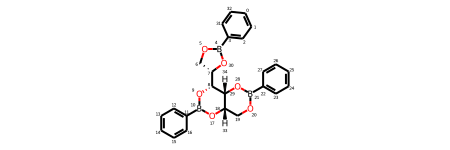

c1ccc(B2OC[C@@H]([C@H]3OB(c4ccccc4)O[C@H]4COB(c5ccccc5)O[C@H]43)O2)cc1
439.8780000000002


In [7]:
# mol = smiles_to_mol('CCCC(=O)/N=c1\sn(C(=O)CCC)c2ccc([N+](=O)[O-])cc12',with_atom_index=False)
mol = smiles_to_mol('c1ccc(B2OC[C@@H]([C@H]3OB(c4ccccc4)O[C@H]4COB(c5ccccc5)O[C@H]43)O2)cc1', with_atom_index=False)
# mol = smiles_to_mol('O=[N+]([O-])c1c(Cl)cc2c(c1Cl)Oc1cc(Cl)c(Cl)cc1O2', with_atom_index=False)
# mol = smiles_to_mol('c1ccc2c3c4c(cc5ccccc5c4cc2c1)C1=C3CCCC1', with_atom_index=False)
# mol = smiles_to_mol('CS(=O)(=O)Nc1ccc(Nc2c3ccc(N=[N+]=[N-])cc3nc3ccc(N=[N+]=[N-])cc23)cc1', with_atom_index=False)
display(mol)
print(Chem.MolToSmiles(mol))
print(Descriptors.MolWt(mol))

In [8]:
recap_frag = recap_frag_smiles_children([mol],limit=[0,100])
print(recap_frag)
len(recap_frag)
try:
    Draw.MolsToGridImage([Chem.MolFromSmiles(f) for f in recap_frag], subImgSize=(150,150), molsPerRow=10)
except Exception as e:
    print(e)

set()
not well-formed (invalid token): line 1, column 1


In [9]:
brics_frag = brics_frag_smiles([mol],limit=[5,100])
print(brics_frag)
len(brics_frag)
try:
    Draw.MolsToGridImage([Chem.MolFromSmiles(f) for f in brics_frag], subImgSize=(150,150), molsPerRow=10)
except Exception as e:
    print(e)

{'C1OB(c2ccccc2)OC2C1OB(c1ccccc1)OC2C1COB(c2ccccc2)O1'}


In [10]:
grinder_frag = grinder_frag_smiles([mol])
display(grinder_frag)
len(grinder_frag)
try:
    Draw.MolsToGridImage([Chem.MolFromSmiles(f) for f in grinder_frag], subImgSize=(150,150), molsPerRow=10)
except Exception as e:
    print(e)

{'*~B1OC(~*)C2OB(~*)OCC2O1',
 '*~B1OCC(~*)O1',
 '*~B1OCC2OB(c3ccccc3)OC(~*)C2O1',
 '*~C1COB(c2ccccc2)O1',
 '*~C1OB(c2ccccc2)OC2COB(c3ccccc3)OC12',
 '*~c1ccccc1'}

In [11]:
# mol_p = Chem.MolFromSmiles('CCCC(=O)/N=c1\sn(C(=O)CCC)c2ccc([N+](=O)[O-])cc12')
# Chem.RemoveStereochemistry(mol_p) 
# display(mol_p)
# # mol_p.UpdatePropertyCache()

# for a in mol_p.GetAtoms():
#     print(a.GetSymbol(), a.GetImplicitValence(), a.GetFormalCharge())
# for b in mol_p.GetBonds():
#     print(b.GetBeginAtomIdx(), b.GetEndAtomIdx(), b.GetBondType(), b.GetStereo())

# print('=====')

# mol_c = Chem.MolFromSmarts('*~n1s/c(=N\C(=O)CCC)c2cc([N+](=O)[O-])ccc21')
# Chem.RemoveStereochemistry(mol_c) 
# display(mol_c)
# # mol_c = Chem.MolFromSmarts('*~N=c1sn(~*)c2ccc([N+](=O)[O-])cc12')
# # mol_c.UpdatePropertyCache()

# for a in mol_c.GetAtoms():
#     print(a.GetSymbol(), a.GetImplicitValence(), a.GetFormalCharge())
# for b in mol_c.GetBonds():
#     print(b.GetBeginAtomIdx(), b.GetEndAtomIdx(), b.GetBondType(), b.GetStereo())
#     # if b.GetStereo() != Chem.rdchem.BondStereo.STEREONONE:
#     #     b.SetBondType(Chem.rdchem.BondStereo.STEREOANY)
#     # print(b.GetBeginAtomIdx(), b.GetEndAtomIdx(), b.GetBondType())

# print(mol_p.GetSubstructMatch(mol_c))
# # if len(mol_p.GetSubstructMatch(mol_c))==0:
# #     print(Chem.MolToSmiles(mol), c_smiles)

# Create fragment dict

In [12]:
fragment_dict = dict()
no_fragment = list()
path = 'dataset/'+file+'/fragment.pickle'

if os.path.exists(path):
    with open(path, 'rb') as handle:
        fragment_dict = pickle.load(handle)
else:
    for g in tqdm(datasets_graph):
        mol = smiles_to_mol(g, with_atom_index=False, kekulize=False)
        limit = [3,20] # 3-20 atoms
        fragment_recap = recap_frag_smiles_children([mol], limit=limit)
        fragment_brics = brics_frag_smiles([mol], limit=limit)
        fragment_grinder = grinder_frag_smiles([mol], limit=limit)
        fragment_all_t = fragment_recap.union(fragment_brics)
        fragment_all = fragment_all_t.union(fragment_grinder)
        fragment_dict[g] = fragment_all
        if len(fragment_all) == 0:
            no_fragment.append(g)
        # break
    
    # write dataset to pickle 
    with open(path, 'wb') as handle:
        pickle.dump(fragment_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
print('fragment_dict', len(fragment_dict))
print('no_fragment', len(no_fragment))

fragment_dict 6505
no_fragment 0


# Test

In [13]:
# # test with dataset
# # test_loader, datasets_test =  generateDataLoaderTesting(datasets_graph[1], args.batch_size)
# # test_loader, datasets_test =  generateDataLoaderTesting([datasets_graph[1][360]], 1)
# test_loader, datasets_test =  generateDataLoaderTesting(args.file, 1)
# sample_to_test = datasets_test[2]
# test_loader, datasets_test =  generateDataLoaderListing([sample_to_test], 1)

# molecule_test = datasets_test[0]
# print(molecule_test)

In [14]:
# test with t = sample
smiles_sample = 'c1ccc2c3c4c(cc5ccccc5c4cc2c1)C1=C3CCCC1'
smiles_sample = 'C[C@H]1CC(=O)O1'
smiles_sample = 'CC(=O)NC1=CC(=C(C=C1[N+](=O)[O-])Cl)Cl'
smiles_sample = 'CS(=O)(=O)C1=CC(=C(C=C1)[N+](=O)[O-])NC2CC2'
smiles_sample = 'C1=CC=C(C=C1)S(=O)(=O)CCNC2=C(C=C(C=C2)S(=O)(=O)N)[N+](=O)[O-]'
smiles_processes = mol_to_smiles(smiles_to_mol(smiles_sample, with_atom_index=False))
mol_process = smiles_to_mol(smiles_processes, with_atom_index=False)
molecule_test = [constructGraph(smiles_processes, 3.5)]
test_loader = DataLoader(molecule_test, batch_size=1, shuffle=True, follow_batch=['x_g', 'x_r'])
molecule_test = molecule_test[0]
print(molecule_test)

PairData(smiles='NS(=O)(=O)c1ccc(NCCS(=O)(=O)c2ccccc2)c([N+](=O)[O-])c1', x_g=[25, 79], edge_index_g=[2, 52], edge_attr_g=[52, 10], y=[1, 1])


In [15]:
tester = Tester(args, args_test)
# tester.test(test_loader, return_attention_weights=True)
tester.test_single(test_loader, return_attention_weights=True)

GNN_Combine(
  (node_feature_graph): NodeLinear(
    (lin1): Linear(in_features=79, out_features=256, bias=True)
    (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (edge_feature_graph): EdgeLinear(
    (lin1): Linear(in_features=10, out_features=32, bias=True)
    (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (GNN_Graph): GNN_Graph(
    (convs): ModuleList(
      (0): GINEConv(nn=Sequential(
        (0): GIN_Sequential(
          (lin1): Linear(in_features=256, out_features=256, bias=True)
          (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (leakyrelu1): LeakyReLU(negative_slope=0.01)
          (lin2): Linear(in_features=256, out_features=256, bias=True)
        )
      ))
      (1): GINEConv(nn=Sequential(
        (0): GIN_Sequential(
          (lin1): Linear(in_features=256, out_features=256, bias=True)
          (bn1): BatchNorm1d(256, e

tensor([[False]])

In [16]:
# att = tester.getAttention()
att_mol = tester.getAttentionMol()
if 'atom' in att_mol:
    if len(args.reduced) >= 1:
        sample_att = (att_mol['atom'], att_mol[args.reduced[0]])
    else:
        sample_att = (att_mol['atom'], None)
else:
    sample_att = (None, att_mol[args.reduced[0]])
sample_graph = molecule_test

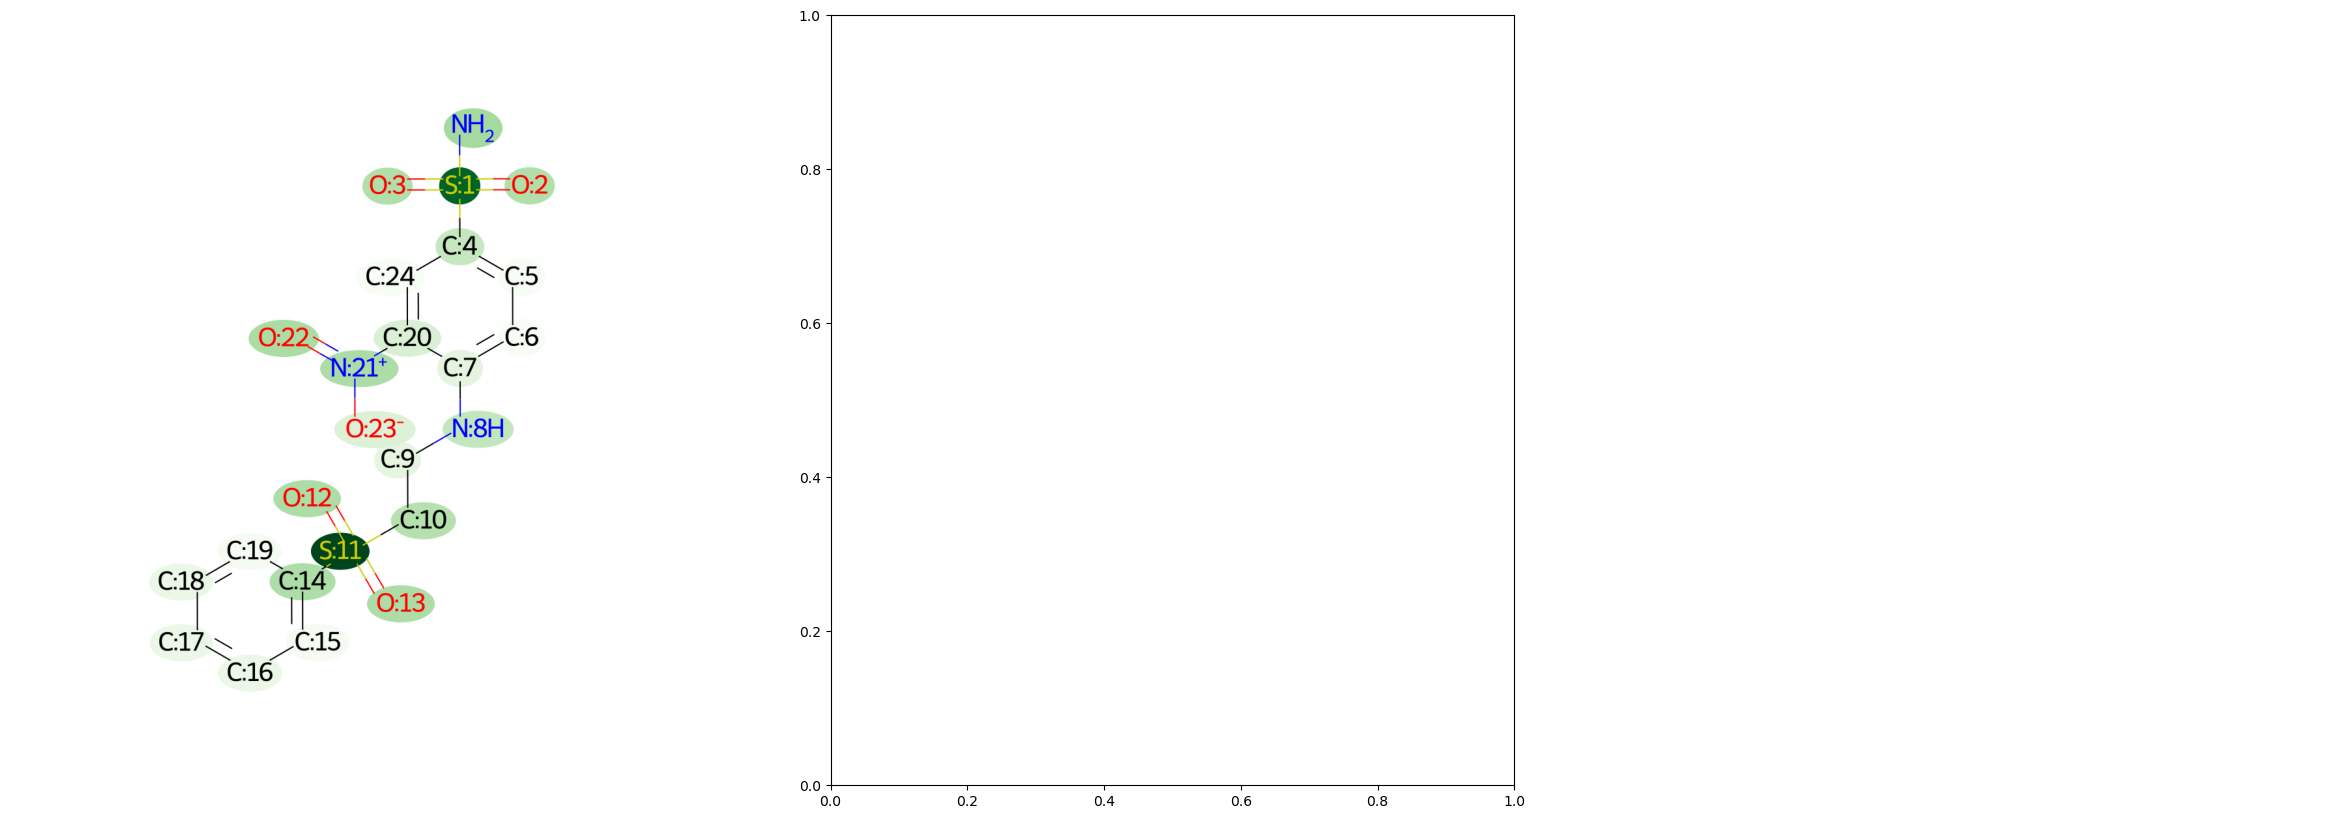

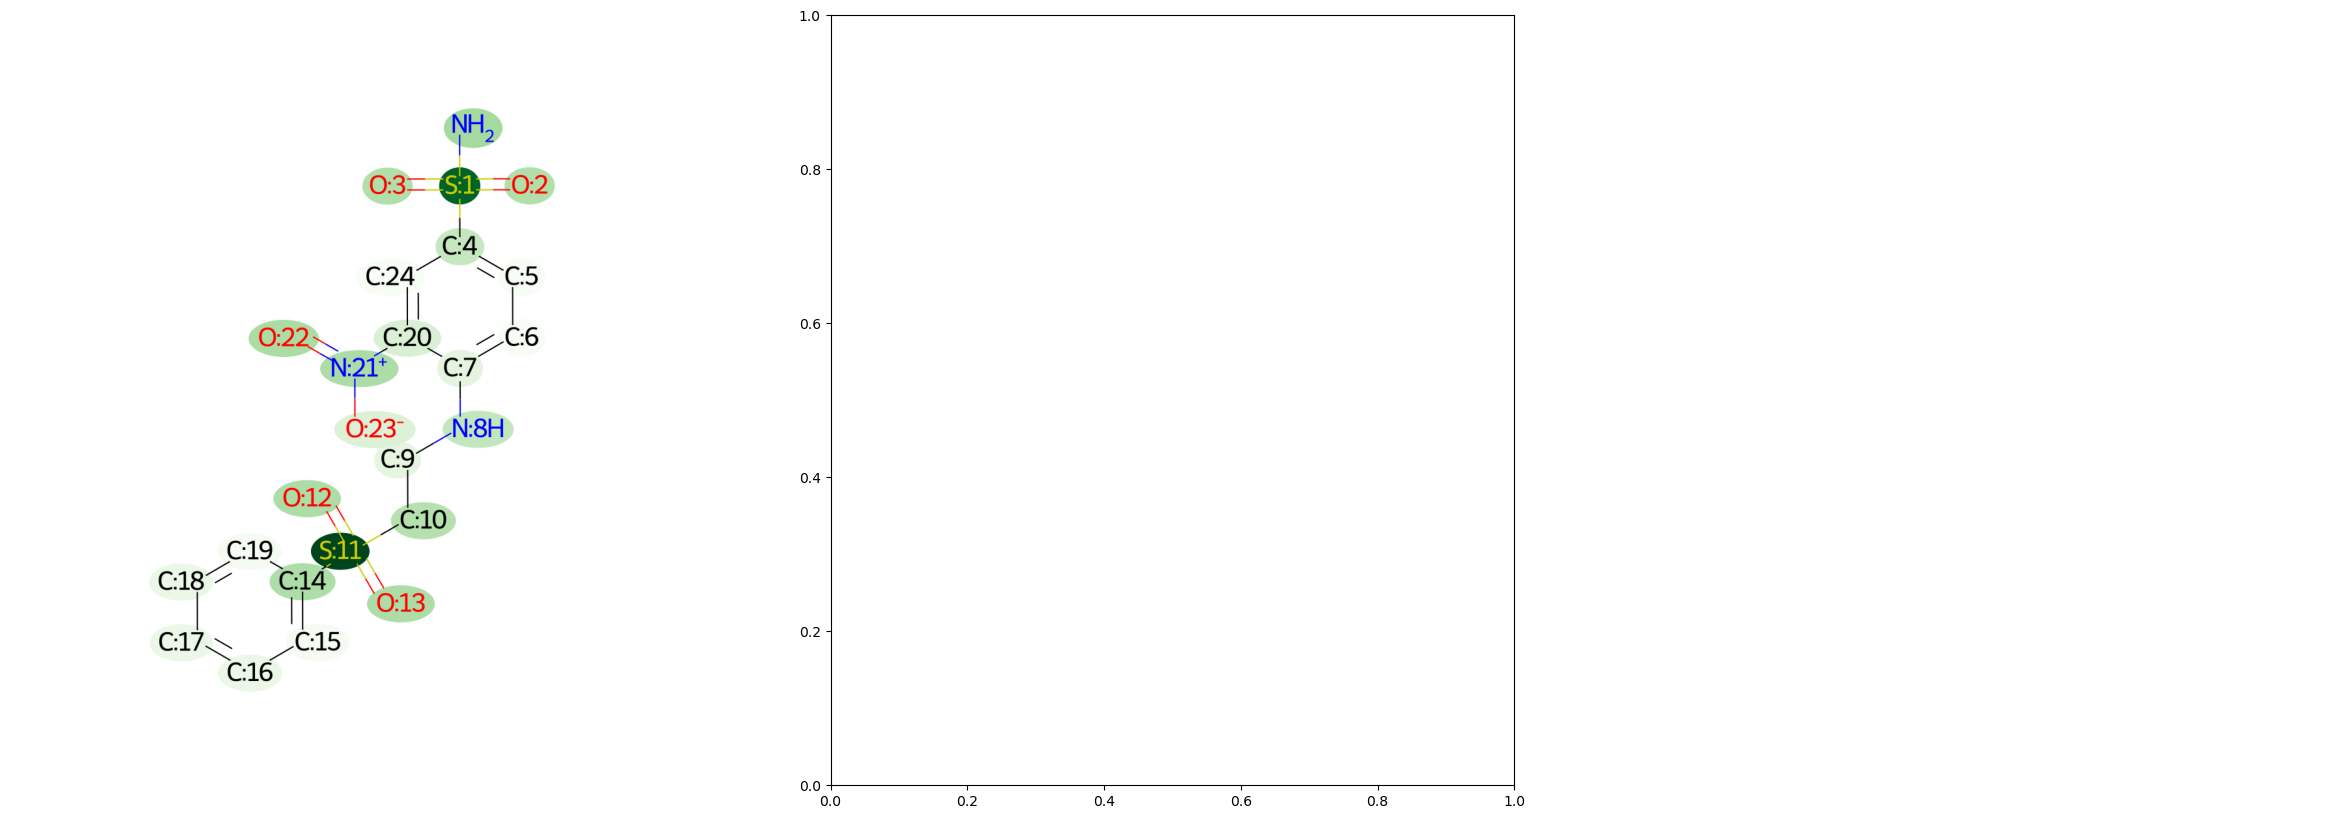

In [17]:
plot_attentions(args, sample_graph, sample_att)

In [18]:
# attention result
att_mol = tester.getAttentionMol()
sample_att = att_mol
sample_graph = molecule_test
if 'atom' in sample_att:
    sample_att_g = sample_att['atom']
else:
    sample_att_g = None
if len(args.reduced) != 0:
    sample_att_r = sample_att[args.reduced[0]]
else:
    sample_att_r = None

# sample_att_g, sample_att_r = sample_att
if args.schema in ['A', 'R_N', 'AR', 'AR_0', 'AR_N']:
    mask_graph_g = mask_graph(sample_att_g)
    print('mask_graph_g')
    print(mask_graph_g)
if args.schema in ['R', 'R_0', 'R_N', 'AR', 'AR_0', 'AR_N']:
    mask_graph_r = mask_reduced(sample_att_r)
    print('mask_graph_r')
    print(mask_graph_r)

print(args.schema)
# record importance
mask_graph_x = None
# if args.schema in ['A']:
if 'A' in args.schema:
    mask_graph_x = mask_graph_g
    # reduced graph
    reduced_graph, cliques, edges = getReducedGraph(args, ['atom'], smiles_processes, normalize=False)
    
if 'R' in args.schema:
    mask_graph_x = mask_graph_r
    # reduced graph
    reduced_graph, cliques, edges = getReducedGraph(args, args.reduced, smiles_processes, normalize=False)
    if not args.schema in ['A']:
        mask_graph_x = mask_rtog(smiles_processes, cliques, mask_graph_r)
        print('mask_graph_x')
        print(mask_graph_x)
        if args.schema in ['AR', 'AR_0', 'AR_N']:
            mask_graph_x = mask_gandr(mask_graph_g, mask_graph_x)
    
    print(mask_graph_x)
    display_interpret_weight(mol_process, None, None, mask_graph_x, None, scale=True)


mask_graph_g
{'atom': {0: 0.36147895005878616, 1: 0.9034677955234085, 2: 0.3275086224403829, 3: 0.3275086224403829, 4: 0.25100643544872697, 5: 0.0, 6: 0.001309965911907851, 7: 0.12851184564867552, 8: 0.26477601694119224, 9: 0.12424431291514584, 10: 0.30514126504359246, 11: 1.0, 12: 0.3365436566461194, 13: 0.3365436566461194, 14: 0.330871107917931, 15: 0.012120284121434927, 16: 0.08392367326703018, 17: 0.08412437789288502, 18: 0.08392367326703018, 19: 0.012120284121434927, 20: 0.17101155234310345, 21: 0.33704615411626127, 22: 0.34394202557847126, 23: 0.15862017322141925, 24: 0.003247384904316003}, 'bond': {}}
A


In [19]:
ff = [12,13,14]
attention_frag = list()
attention_nonfrag = list()
for i in mask_graph_x['atom']:
    if i in ff:
        attention_frag.append(mask_graph_x['atom'][i])
    else:
        attention_nonfrag.append(mask_graph_x['atom'][i])
# if np.sum(attention_frag+attention_nonfrag) != 0:
#     p = np.sum(attention_frag)/np.sum(attention_frag+attention_nonfrag)
# else:
#     p = 0
# p = np.average(attention_frag)
print(attention_frag)
p = np.median(attention_frag)
print('p', p)
# threshold = 0.5
threshold = np.percentile(attention_frag+attention_nonfrag, 70)
print('threshold', threshold)
print(p >= threshold)

U1, p = mannwhitneyu(attention_frag, attention_nonfrag, alternative = 'greater')
print("p-value", p)
print(attention_frag, attention_nonfrag)


[0.3365436566461194, 0.3365436566461194, 0.330871107917931]
p 0.3365436566461194
threshold 0.33019861082242136
True
p-value 0.07152179388035204
[0.3365436566461194, 0.3365436566461194, 0.330871107917931] [0.36147895005878616, 0.9034677955234085, 0.3275086224403829, 0.3275086224403829, 0.25100643544872697, 0.0, 0.001309965911907851, 0.12851184564867552, 0.26477601694119224, 0.12424431291514584, 0.30514126504359246, 1.0, 0.012120284121434927, 0.08392367326703018, 0.08412437789288502, 0.08392367326703018, 0.012120284121434927, 0.17101155234310345, 0.33704615411626127, 0.34394202557847126, 0.15862017322141925, 0.003247384904316003]


## Running

In [20]:
all_dataset = datasets_graph
print('Number of dataset:', len(all_dataset))

Number of dataset: 6505


In [21]:
tester = Tester(args, args_test)

GNN_Combine(
  (node_feature_graph): NodeLinear(
    (lin1): Linear(in_features=79, out_features=256, bias=True)
    (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (edge_feature_graph): EdgeLinear(
    (lin1): Linear(in_features=10, out_features=32, bias=True)
    (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (GNN_Graph): GNN_Graph(
    (convs): ModuleList(
      (0): GINEConv(nn=Sequential(
        (0): GIN_Sequential(
          (lin1): Linear(in_features=256, out_features=256, bias=True)
          (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (leakyrelu1): LeakyReLU(negative_slope=0.01)
          (lin2): Linear(in_features=256, out_features=256, bias=True)
        )
      ))
      (1): GINEConv(nn=Sequential(
        (0): GIN_Sequential(
          (lin1): Linear(in_features=256, out_features=256, bias=True)
          (bn1): BatchNorm1d(256, e

In [22]:
# distribution
attention_distribution = list()
# score
feature_score = dict()

list_features = list()
attention_substructure = dict()

# count found substructure
count_substructure = dict()

# num substructure
num_substructure = dict()

# psub
psub_all = set()
psub_after = list()

count = 0 

count_1000 = list()
count_1 = list()

threshold_list = list()

for d in tqdm(all_dataset):

    # data loader
    test_loader, datasets_test =  generateDataLoaderListing([all_dataset[d]], 1)
    molecule_test = datasets_test[0]

    # molecule
    smiles_test = molecule_test.smiles
    mol_test = smiles_to_mol(smiles_test, with_atom_index=False, kekulize=False)
    if mol_test.GetNumAtoms() > 100:
        count_1000.append(smiles_test)
    #     continue

    # testing
    # print(datasets_test)
    try:
        predicted = tester.test_single(test_loader, return_attention_weights=True, print_result=False)
    except:
        predicted = None

    # if predicted != molecule_test.y:
    #     print(molecule_test.smiles, "TRUE:", molecule_test.y, "PREDICTED:", predicted)

    if predicted is not None:
        # print(predicted)
        try:
            predicted = predicted.item()
        except:
            predicted = predicted[0][0]

        # regression record as 1
        if args.graphtask == 'regression':
            predicted = 1

        if predicted not in attention_substructure:
            attention_substructure[predicted] = dict()
            count_substructure[predicted] = dict()
            num_substructure[predicted] = dict()
            feature_score[predicted] = dict()

        count += 1

        # attention result
        att_mol = tester.getAttentionMol()
        sample_att = att_mol
        sample_graph = molecule_test
        if 'atom' in sample_att:
            sample_att_g = sample_att['atom']
        else:
            sample_att_g = None
        if len(args.reduced) != 0:
            sample_att_r = sample_att[args.reduced[0]]
        else:
            sample_att_r = None
        # sample_att_g, sample_att_r = sample_att
        if args.schema in ['A', 'R_N', 'AR', 'AR_0', 'AR_N']:
            mask_graph_g = mask_graph(sample_att_g)
        if args.schema in ['R', 'R_0', 'R_N', 'AR', 'AR_0', 'AR_N']:
            mask_graph_r = mask_reduced(sample_att_r)

        # molecule
        smiles = sample_graph.smiles
        mol = smiles_to_mol(smiles, with_atom_index=False, kekulize=False)

        if smiles not in count_substructure[predicted]:
            count_substructure[predicted][smiles] = list()

        # record importance
        mask_graph_x = None
        # if args.schema in ['A']:
        if 'A' in args.schema:
            mask_graph_x = mask_graph_g

            # reduced graph
            reduced_graph, cliques, edges = getReducedGraph(args, ['atom'], smiles, normalize=False)

            # for i, f in enumerate(reduced_graph.node_features):
            #     # getImportanceFeatures
            #     f_tuple = getImportanceFeatures(['atom'], f)

            #     list_features.append(f_tuple)


        # elif args.schema in ['R', 'R_0', 'R_N', 'AR', 'AR_0', 'AR_N']:
        if 'R' in args.schema:
            mask_graph_x = mask_graph_r

            # reduced graph
            reduced_graph, cliques, edges = getReducedGraph(args, args.reduced, smiles, normalize=False)

            if not args.schema in ['A']:
                mask_graph_x = mask_rtog(smiles, cliques, mask_graph_r)
                if args.schema in ['AR', 'AR_0', 'AR_N']:
                    mask_graph_x = mask_gandr(mask_graph_g, mask_graph_x)

            # for i, f in enumerate(reduced_graph.node_features):
            #     # getImportanceFeatures
            #     if len(args.reduced) == 0:
            #         f_tuple = getImportanceFeatures(['atom'], f)
            #     elif 'substructure' not in args.reduced:
            #         f_tuple = getImportanceFeatures(args.reduced, f)
            #     else:
            #         f_tuple = getImportanceFeatures(args.reduced, reduced_graph.cliques_smiles[i])

            #     list_features.append(f_tuple)
        
        # distribution
        attention_distribution.append(list(mask_graph_x['atom'].values()))
        # average
        mol_avg = np.mean(list(mask_graph_x['atom'].values()))
            
        # get series of reasonable fragments
        # print(smiles)
        if smiles in fragment_dict:
            fragment_all = fragment_dict[smiles]
        else:
            limit = [3,20] # 3-20 atoms
            fragment_recap = recap_frag_smiles_children([mol], limit=limit)
            fragment_brics = brics_frag_smiles([mol], limit=limit)
            fragment_grinder = grinder_frag_smiles([mol], limit=limit)
            fragment_all_t = fragment_recap.union(fragment_brics)
            fragment_all = fragment_all_t.union(fragment_grinder)

        # print(fragment_all)
        if len(fragment_all) == 1:
            count_1.append(smiles)
            # print(smiles)

        frag_smarts_passed = list()

        threshold = None

        for frag in fragment_all:

            frag_smarts = frag
            frag_mol = Chem.MolFromSmarts(frag_smarts)

            frag_match = mol.GetSubstructMatches(frag_mol)
        
            # print(children_match)
            
            for ff in frag_match:
                attention_frag = list()
                attention_nonfrag = list()
                # print(ff)
                for i in mask_graph_x['atom']:
                    if i in ff:
                        attention_frag.append(mask_graph_x['atom'][i])
                    else:
                        attention_nonfrag.append(mask_graph_x['atom'][i])
                assert len(attention_frag) == len(ff)
                assert len(attention_frag)+len(attention_nonfrag) == len(mask_graph_x['atom'])
                try:
                    # if np.sum(attention_frag+attention_nonfrag) != 0:
                    #     p = np.sum(attention_frag)/np.sum(attention_frag+attention_nonfrag)
                    # else:
                    #     p = 0
                    # p = np.average(attention_frag)
                    p = np.median(attention_frag)
                    # threshold = 0.5
                    percentile_value = 75
                    if 't04' in args.file:
                        percentile_value = 70
                    threshold = np.percentile(attention_frag+attention_nonfrag, percentile_value)
                    
                    # U1, p = mannwhitneyu(attention_frag, attention_nonfrag, alternative = 'greater')
                    # print(p, attention_frag, attention_nonfrag)
                    if p >= threshold:
                        if frag_smarts in attention_substructure[predicted]:
                            attention_substructure[predicted][frag_smarts].append(smiles)
                        else:
                            attention_substructure[predicted][frag_smarts] = [smiles]
                        frag_smarts_passed.append(frag_smarts)
                        count_substructure[predicted][smiles].append(frag_smarts)

                    # score
                    f_avg = np.mean(attention_frag)
                    if frag_smarts in feature_score[predicted]:
                        feature_score[predicted][frag_smarts].append(f_avg-mol_avg)
                    else:
                        feature_score[predicted][frag_smarts] = [f_avg-mol_avg]

                except ValueError:
                    pass
            
                if frag_smarts not in num_substructure[predicted]:
                    num_substructure[predicted][frag_smarts] = [smiles]
                else:
                    num_substructure[predicted][frag_smarts].append(smiles)

                # print(attention_substructure)
                # display_interpret_weight(mol, cliques, edges, None, mask_graph_r, scale=True)
        
        if threshold is not None and predicted == 1: threshold_list.append(threshold) 
        
        psub_all.update(frag_smarts_passed)

print('count_1000', len(count_1000))
print('count_1', len(count_1))

100%|██████████| 6505/6505 [05:12<00:00, 20.82it/s]

count_1000 5
count_1 288


# Prediction number

In [23]:
print("0:", len(count_substructure[0]))
print("1:", len(count_substructure[1]))


0: 2597
1: 3908


In [24]:
print(len(psub_all))

8298


In [25]:
print(len(threshold_list), np.mean(threshold_list), np.std(threshold_list))

3694 0.44969391368125716 0.22974530110959454


In [26]:
# psub_all

# Score

In [46]:
df_score_dict = dict()

In [47]:
predicted = 0
df_featurename = list()
df_featurescore = list()
for i in feature_score[predicted]:
    sum_score = np.sum(feature_score[predicted][i])
    score = sum_score/len(feature_score[predicted][i])
    df_featurename.append(i)
    df_featurescore.append(score)
df_score_dict[predicted] = pd.DataFrame({'fragment': df_featurename, 'score': df_featurescore}).sort_values(by='score', ascending=False).reset_index(drop=True)
display(df_score_dict[predicted])

fragment     score
0                         *~C1CO1  0.411927
1                      *~CN1CCCC1  0.388819
2                   *~SC(~*)(F)Cl  0.371103
3                  *~SC(~*)(Cl)Cl  0.371103
4                   *~SC(F)(Cl)Cl  0.371103
...                           ...       ...
131341                 *~c1nnnn1C -0.268019
131342                *~c1nnnn1~* -0.268019
131343               *~Sc1nnnn1~* -0.271232
131344                *~Sc1nnnn1C -0.271232
131345  *~c1ccc(Cc2ccc(~*)cc2)cc1 -0.343249

[131346 rows x 2 columns]

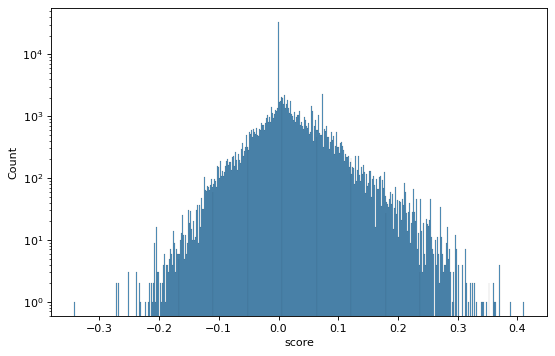

In [48]:
figure(figsize=(8, 5), dpi=80)
fig = sns.histplot(df_score_dict[predicted]['score'])
fig.set_yscale("log")

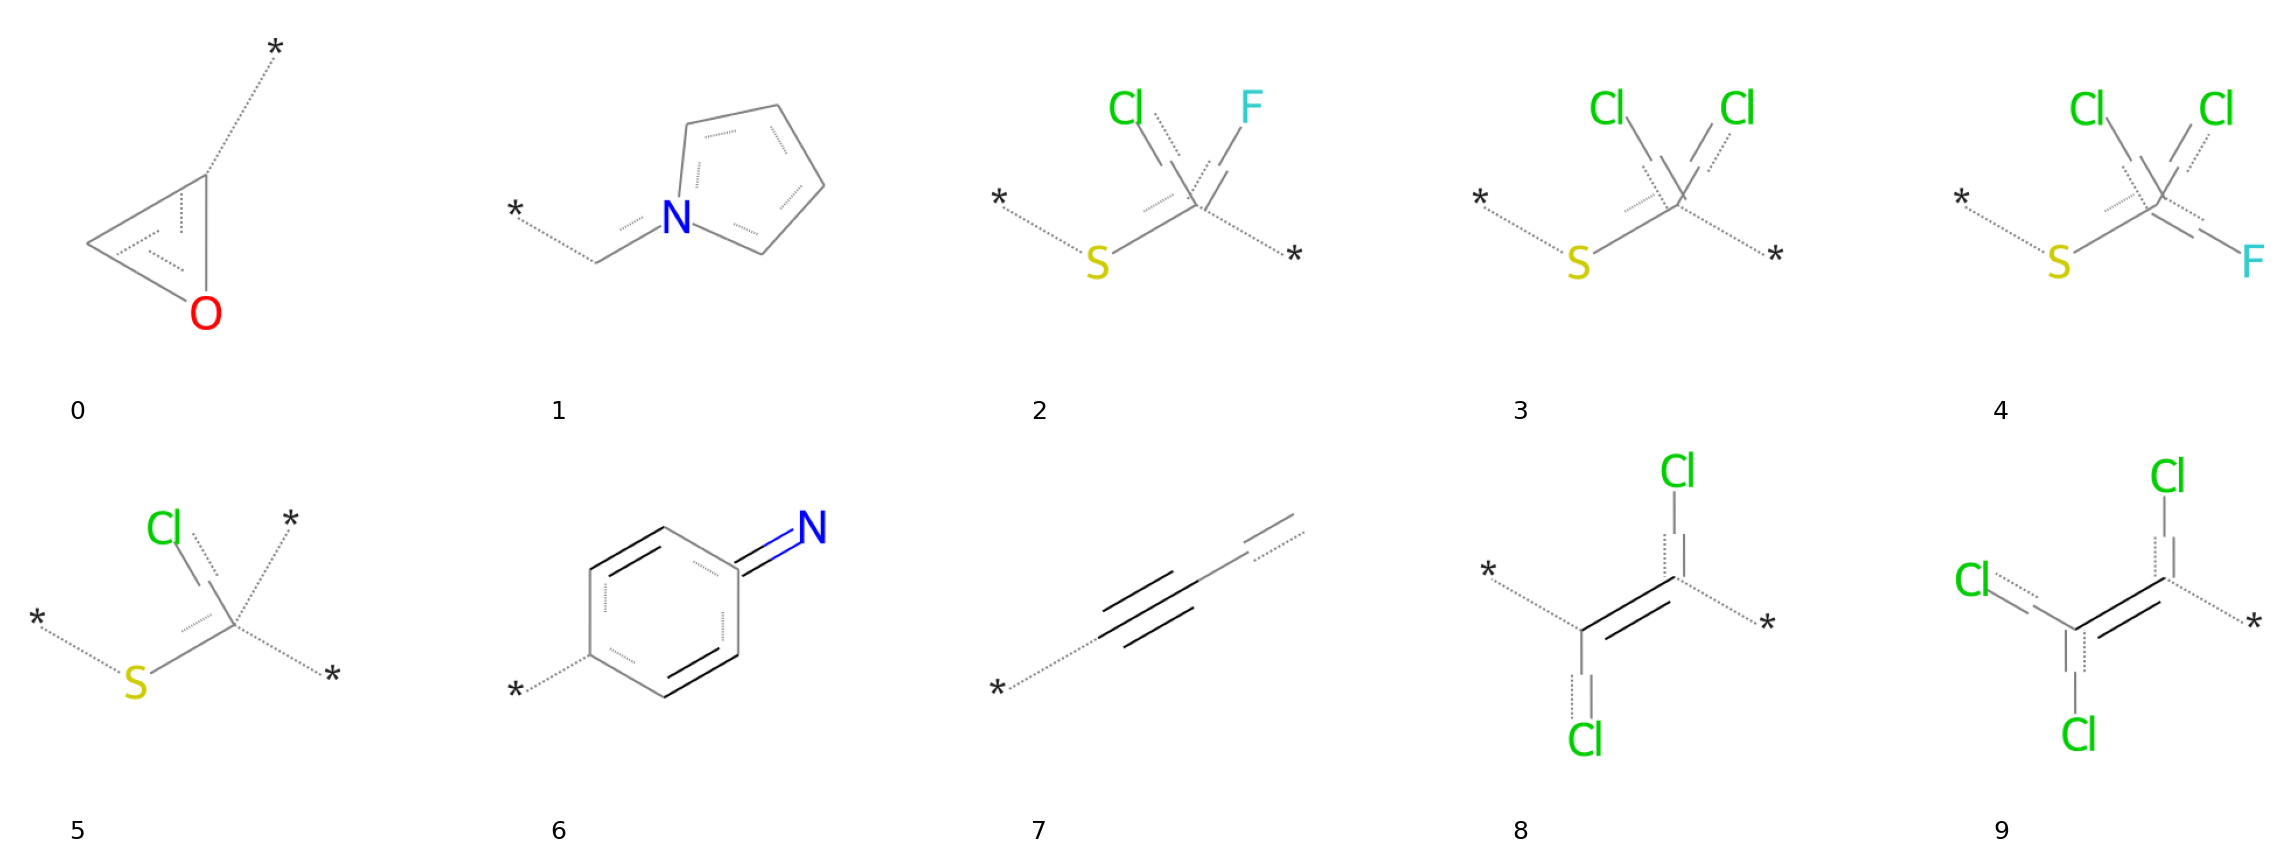

In [49]:
top10_0 = df_score_dict[predicted][:10]
drawGridMolecule([Chem.MolFromSmarts(t) for t in top10_0['fragment']], labels=range(len(top10_0)))

In [50]:
predicted = 1
df_featurename = list()
df_featurescore = list()
for i in feature_score[predicted]:
    sum_score = np.sum(feature_score[predicted][i])
    score = sum_score/len(feature_score[predicted][i])
    df_featurename.append(i)
    df_featurescore.append(score)
df_score_dict[predicted] = pd.DataFrame({'fragment': df_featurename, 'score': df_featurescore}).sort_values(by='score', ascending=False).reset_index(drop=True)
display(df_score_dict[predicted])

fragment     score
0           *~CCC=CCC~*  0.391972
1           *~C=CCC=C~*  0.367758
2                *~NC=C  0.360486
3       *~C=CCC=CCC=C~*  0.354871
4             *~N(O)C=O  0.347281
...                 ...       ...
120531     *~OP(O~*)O~* -0.366369
120532   *~OP(O)(=O)O~* -0.400278
120533   *~OP(~*)(O)O~* -0.400278
120534    *~OP(~*)(O)=O -0.407625
120535    *~OP(~*)(~*)O -0.407625

[120536 rows x 2 columns]

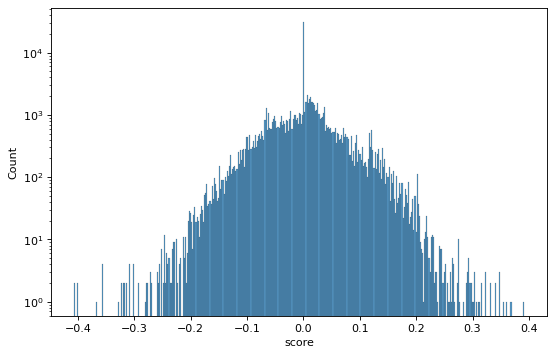

In [51]:
figure(figsize=(8, 5), dpi=80)
fig = sns.histplot(df_score_dict[predicted]['score'])
fig.set_yscale("log")

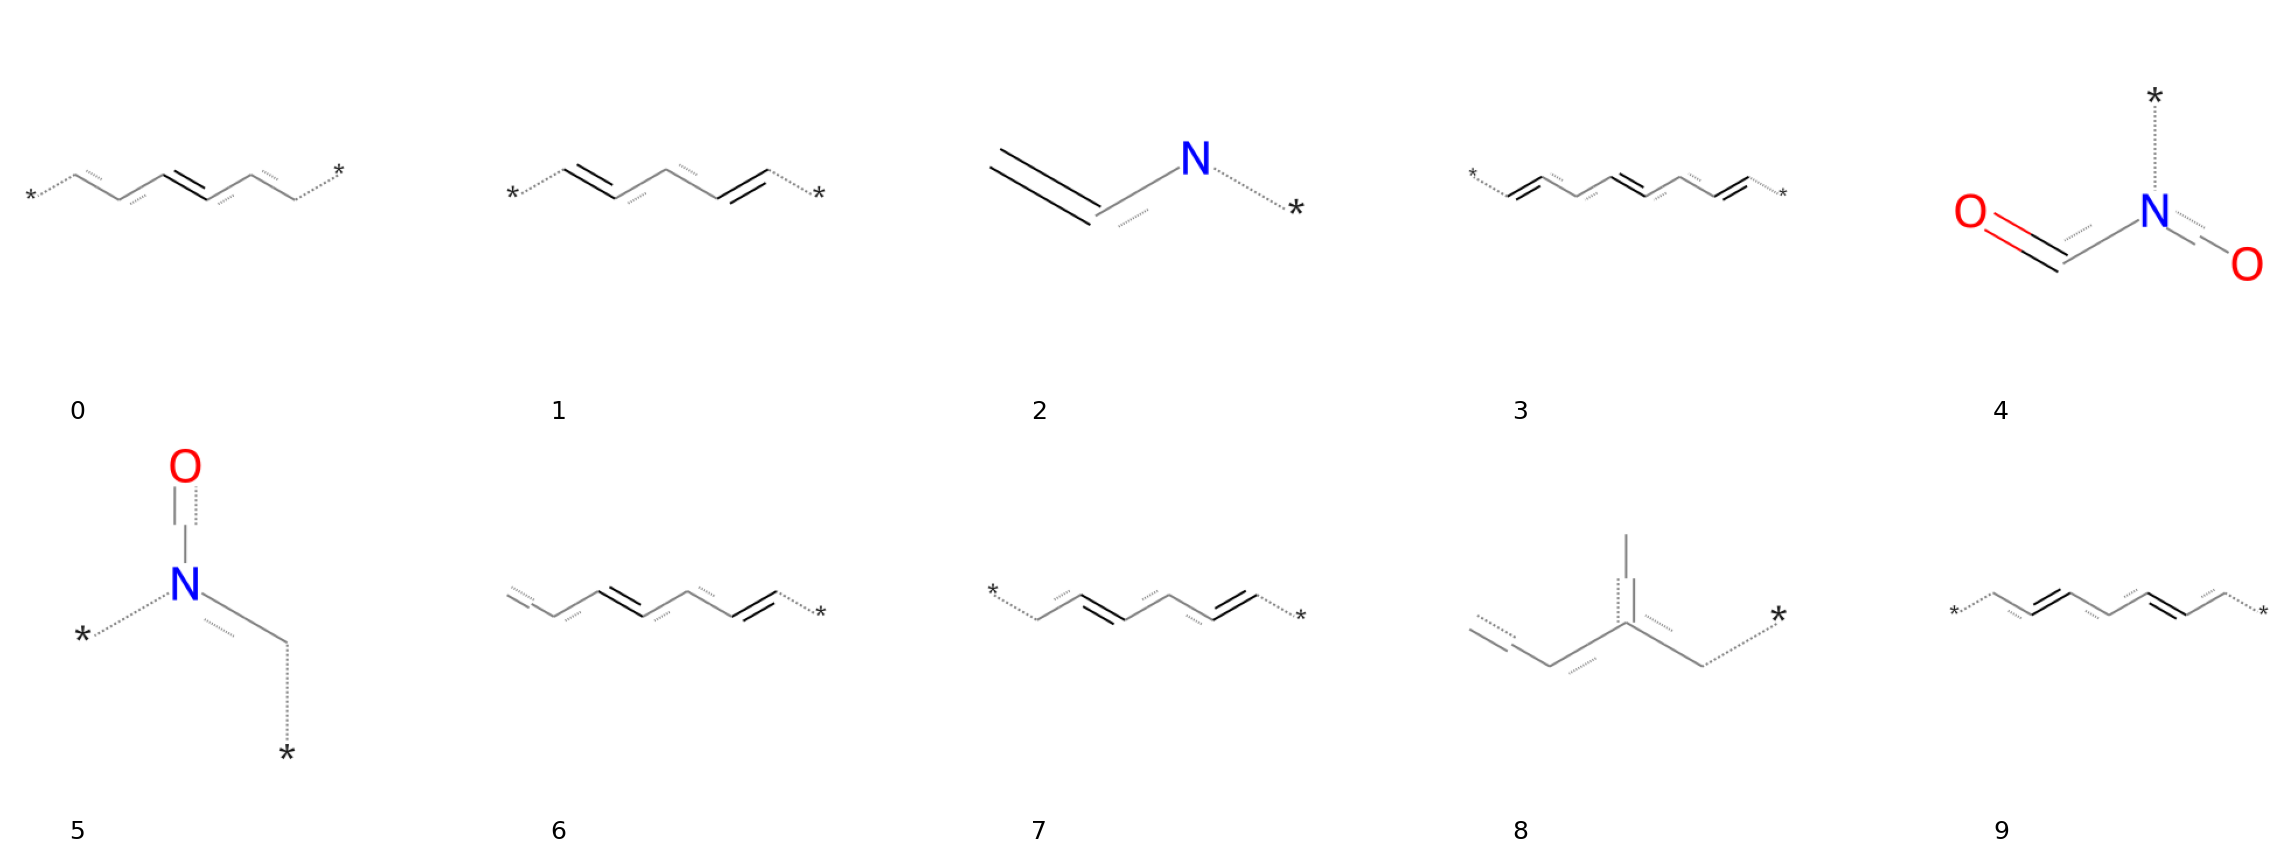

In [52]:
top10_1 = df_score_dict[predicted][:10]
drawGridMolecule([Chem.MolFromSmarts(t) for t in top10_1['fragment']], labels=range(len(top10_1)))

# Attention Substructure

In [53]:
# Class 1
predicted = 1
att_0 = dict(sorted(attention_substructure[predicted].items(), key=lambda item: len(set(item[1])), reverse=True))
print(len(att_0))
for i, a in enumerate(att_0):
    if i < 10:
        print(a, len(att_0[a]), len(set(att_0[a])))
        # display(Chem.MolFromSmarts(a))
print('and more...')


4052
*~[N+](=O)[O-] 707 628
*~N(~*)N=O 106 106
*~C1CO1 85 79
*~S(~*)(=O)=O 86 70
*~N=[N+]=[N-] 65 61
*~C(=O)N(~*)~* 59 59
*~NC(~*)=O 75 58
*~CCCl 70 57
*~C(C)=O 62 54
*~CC1CO1 55 51
and more...


4052
One element fragments
Two element fragments


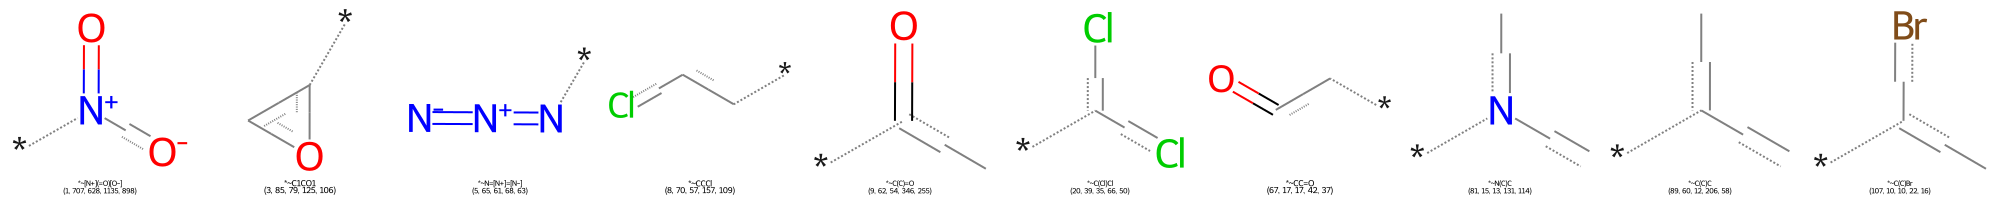

Three element fragments


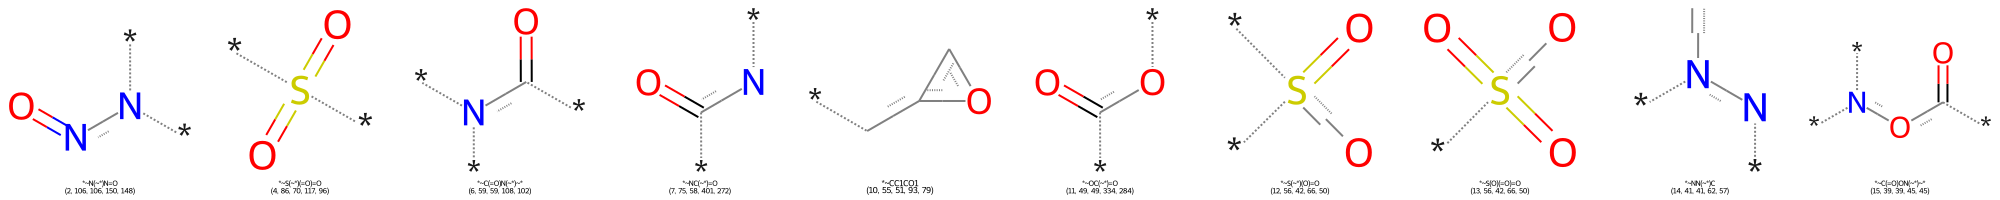

In [54]:
# Class 1
predicted = 1
sub_one = (list(), list(), list())
sub_two = (list(), list(), list())
sub_three = (list(), list(), list())
sub_all = (list(), list(), list())
limit = 10
att_1 = dict(sorted(attention_substructure[predicted].items(), key=lambda item: len(set(item[1])), reverse=True))
print(len(att_1))

for i, a in enumerate(att_1):
    # print(a, att_1[a])
    sub_mol = Chem.MolFromSmarts(a)
    sub_atom = sub_mol.GetNumAtoms()
    try:
        sub_mol_smiles = Chem.MolFromSmiles(a)
        Chem.Kekulize(sub_mol_smiles, clearAromaticFlags=True)
    except:
        if len(sub_all[0]) < 20:
            print('EXCEPT')
            print(a)
        # break
        # sub_mol_smiles = Chem.MolFromSmiles(smiles)
        # Chem.Kekulize(sub_mol_smiles, clearAromaticFlags=True)
        # continue
    # print(sub_atom)
    if sub_atom <= 3 and len(sub_one[0]) < limit:
        sub_one[0].append(a)
        sub_one[1].append(sub_mol)
        sub_one[2].append((i+1, len(att_1[a]), len(set(att_1[a])), len(num_substructure[predicted][a]), len(set(num_substructure[predicted][a]))))
    elif sub_atom == 4 and len(sub_two[0]) < limit:
        sub_two[0].append(a)
        sub_two[1].append(sub_mol)
        sub_two[2].append((i+1, len(att_1[a]), len(set(att_1[a])), len(num_substructure[predicted][a]), len(set(num_substructure[predicted][a]))))
    elif len(sub_three[0]) < limit:
        sub_three[0].append(a)
        sub_three[1].append(sub_mol)
        sub_three[2].append((i+1, len(att_1[a]), len(set(att_1[a])), len(num_substructure[predicted][a]), len(set(num_substructure[predicted][a]))))
    if len(sub_all[0]) < 50:
        sub_all[0].append(a)
        sub_all[1].append(sub_mol)
        sub_all[2].append((i+1, len(att_1[a]), len(set(att_1[a])), len(num_substructure[predicted][a]), len(set(num_substructure[predicted][a]))))
    # display(Chem.MolFromSmarts(a))


# IPythonConsole.drawOptions.addAtomIndices = False
print('One element fragments') # depending number of atoms
# display(Draw.MolsToImage(sub_one[1],legends=[s1+'\n'+str(s2) for s1, s2 in zip(sub_one[0],sub_one[2])]))
print('Two element fragments') # depending number of atoms
display(Draw.MolsToImage(sub_two[1],legends=[s1+'\n'+str(s2) for s1, s2 in zip(sub_two[0],sub_two[2])]))
print('Three element fragments') # depending number of atoms
display(Draw.MolsToImage(sub_three[1],legends=[s1+'\n'+str(s2) for s1, s2 in zip(sub_three[0],sub_three[2])]))
# print('Unlimited element fragments') # depending number of atoms
# display(Draw.MolsToGridImage(sub_all[1],legends=[s1+'\n'+str(s2) for s1, s2 in zip(sub_all[0],sub_all[2])], molsPerRow=5))

Three element fragments


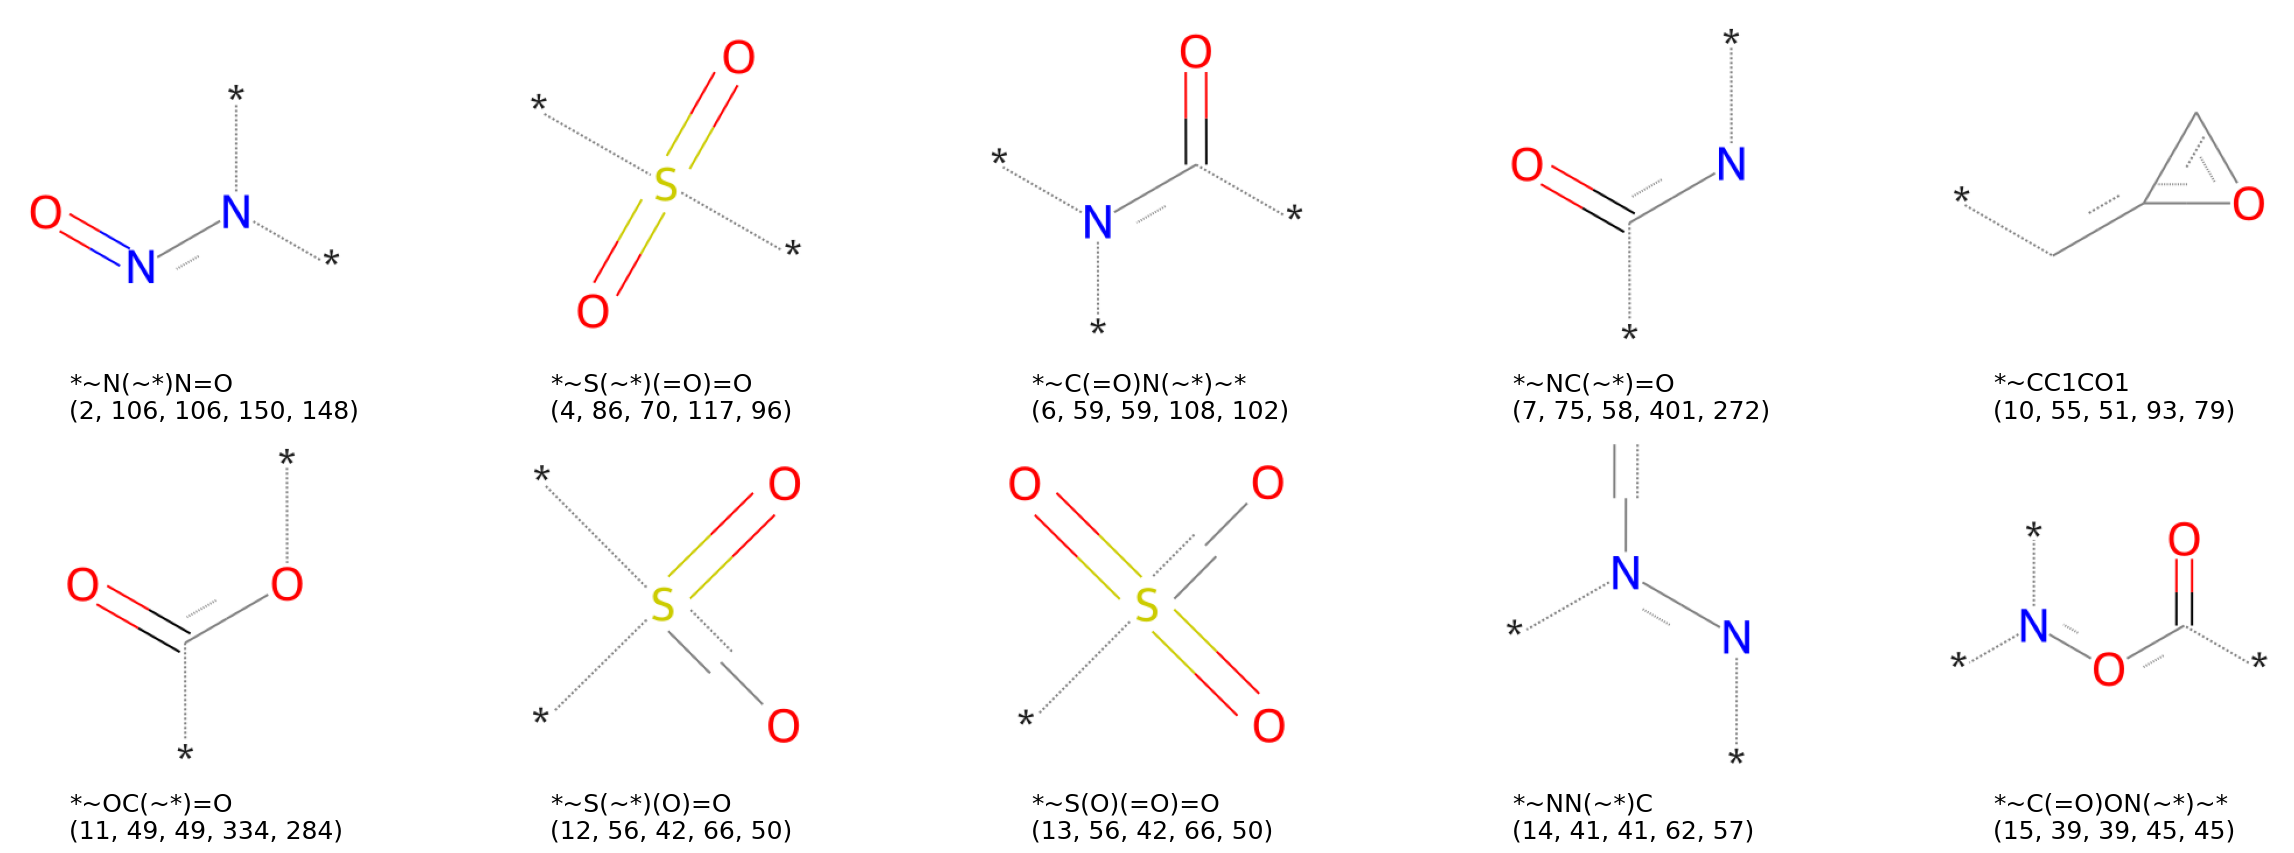

In [55]:
print('Three element fragments')
drawGridMolecule(sub_three[1], labels=[s1+'\n'+str(s2) for s1, s2 in zip(sub_three[0],sub_three[2])])

Unlimited element fragments


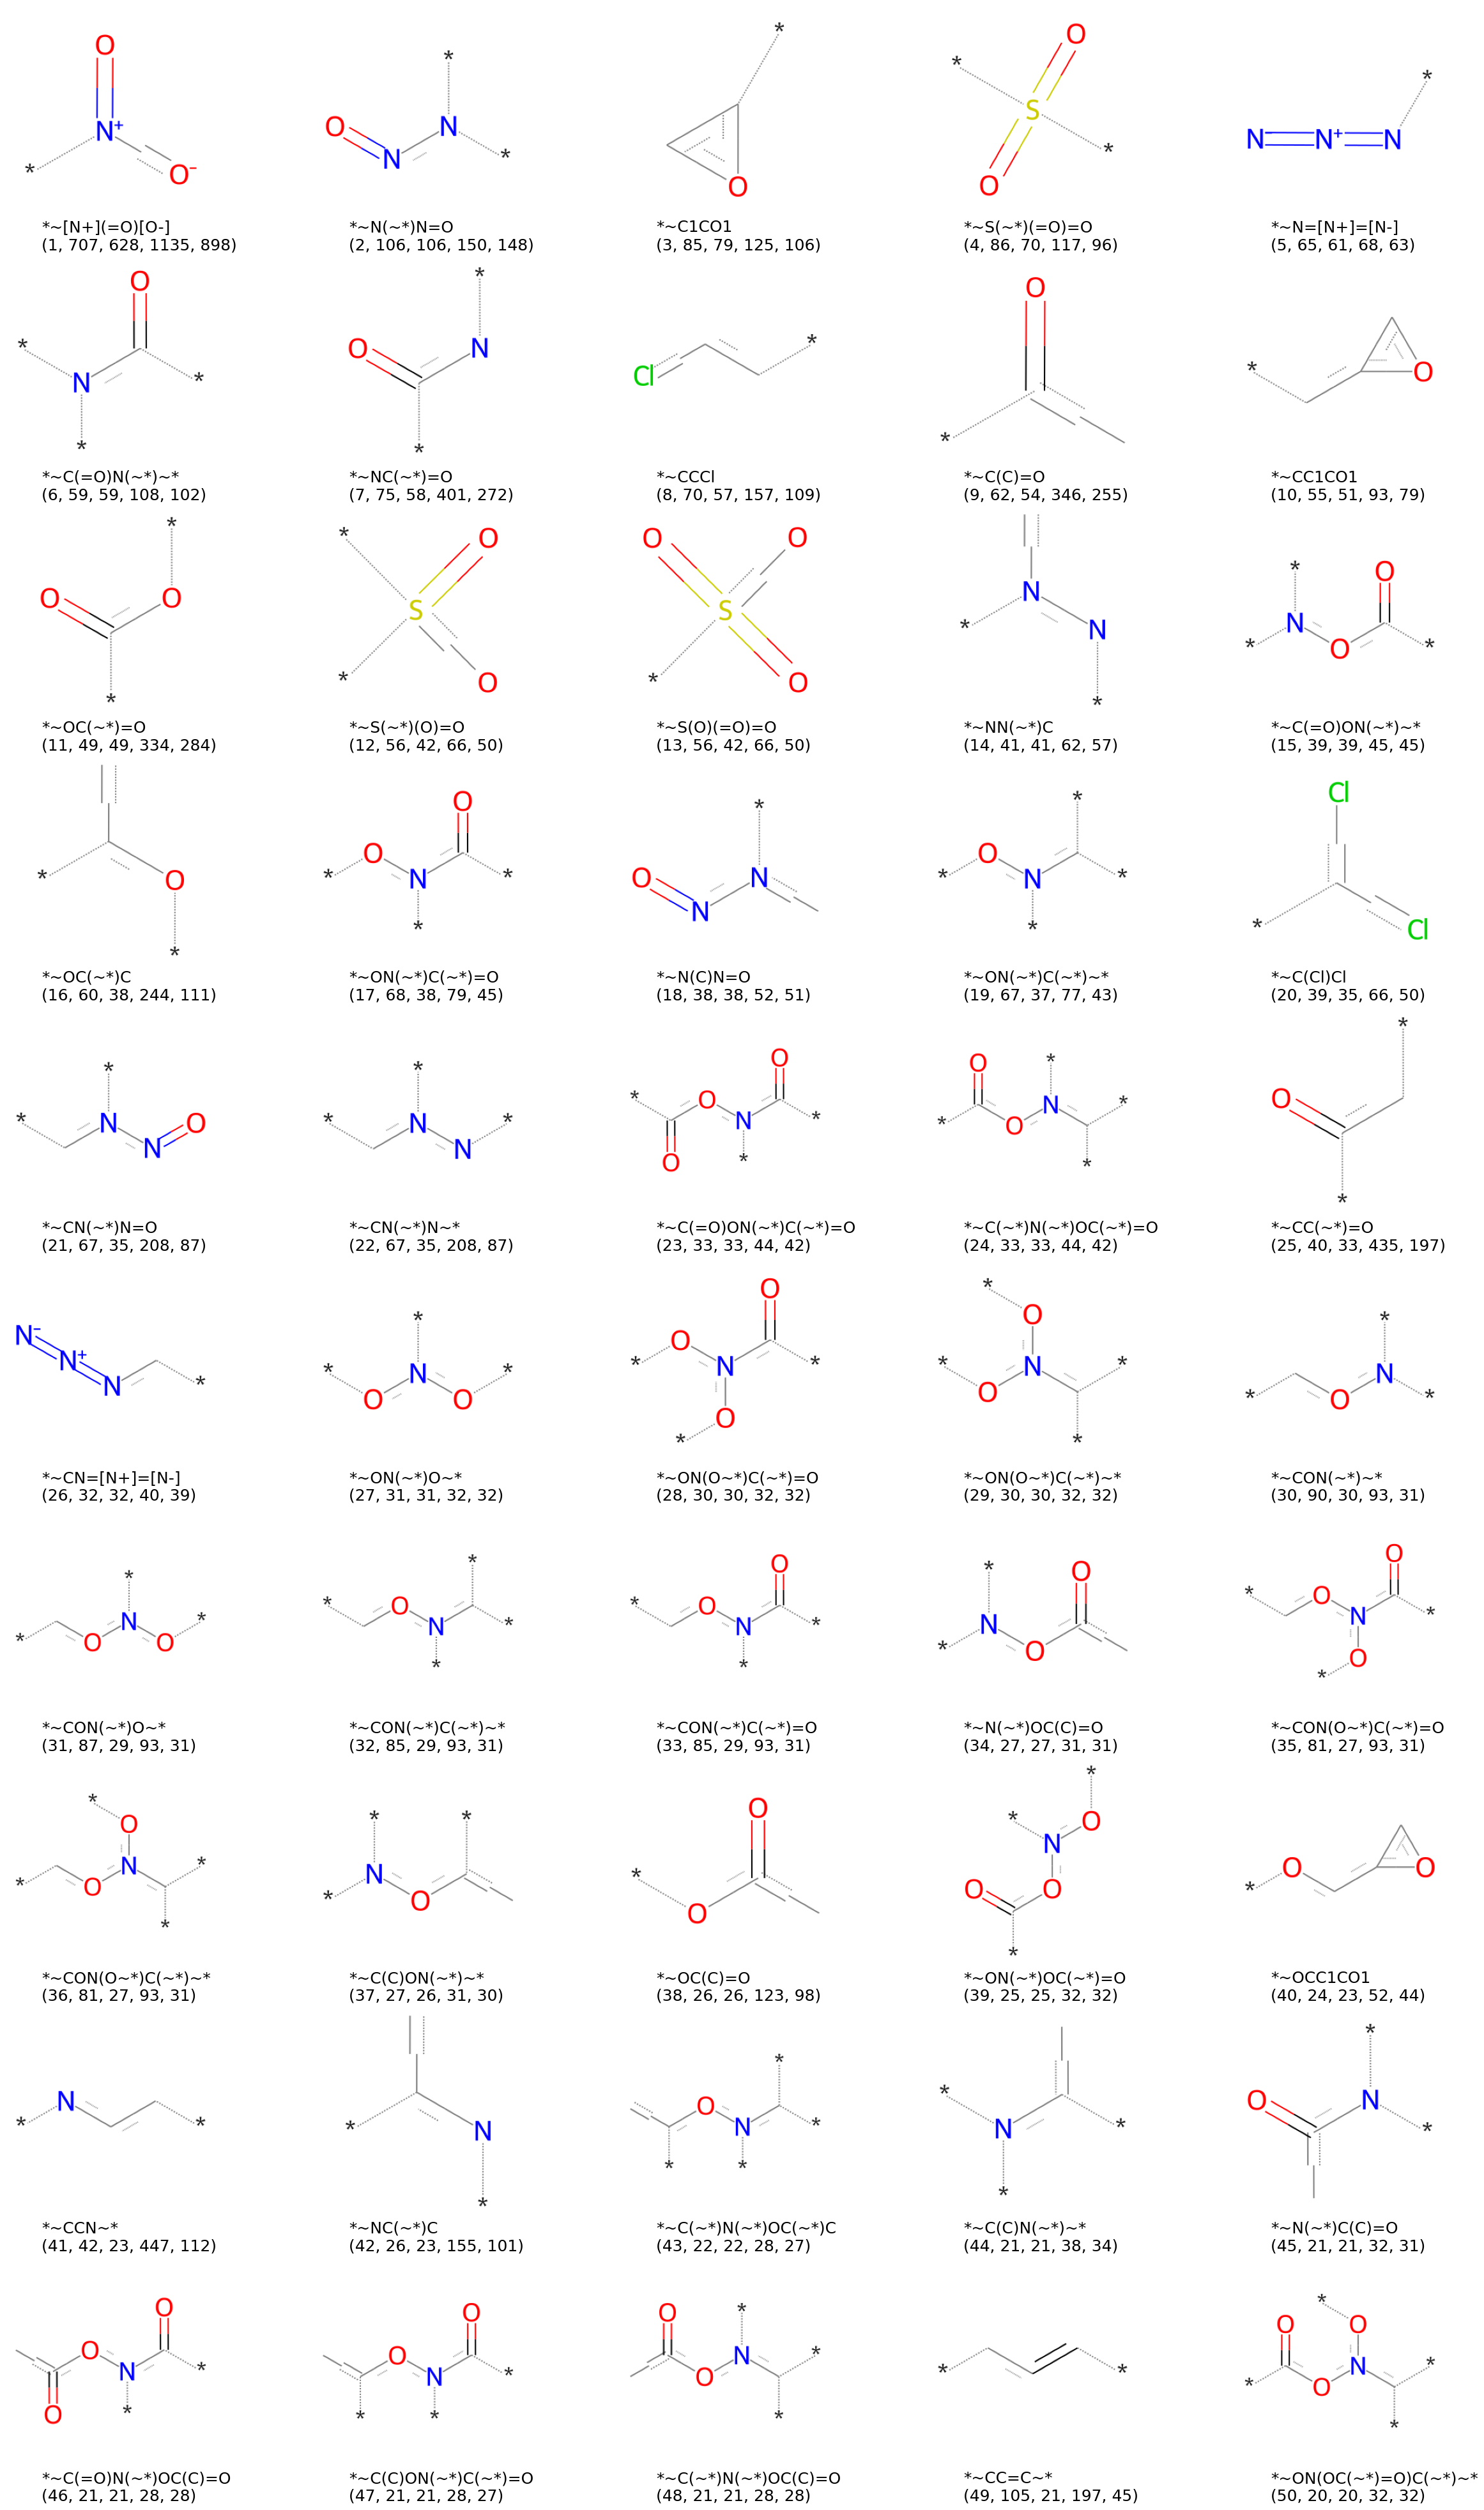

In [56]:
print('Unlimited element fragments')
drawGridMolecule(sub_all[1], labels=[s1+'\n'+str(s2) for s1, s2 in zip(sub_all[0],sub_all[2])])

# Number of fragments

In [57]:
if args.graphtask == 'classification':
    count_number_0 = 0
    count_number_0_all = 0
    for c in count_substructure[0]:
        count_number_0_all += 1
        if len(count_substructure[0][c])> 0:
            count_number_0 += 1
            # print(c, len(count_substructure[0][c]))
    count_number_1 = 0
    count_number_1_all = 0
    for c in count_substructure[1]:
        count_number_1_all += 1
        if len(count_substructure[1][c])> 0:
            count_number_1 += 1
            # print(c, len(count_substructure[1][c]))

    print('Predicted as 0:')
    print('- Number of smiles that have important fragments:', count_number_0_all)
    print('- Number of smiles that have important fragments > 1:', count_number_0)
    print('- Percentage:', count_number_0/count_number_0_all)
    print('Predicted as 1:')
    print('- Number of smiles that have important fragments:', count_number_1_all)
    print('- Number of smiles that have important fragments > 1:', count_number_1)
    print('- Percentage:', count_number_1/count_number_1_all)

Predicted as 0:
- Number of smiles that have important fragments: 2597
- Number of smiles that have important fragments > 1: 1129
- Percentage: 0.4347323835194455
Predicted as 1:
- Number of smiles that have important fragments: 3908
- Number of smiles that have important fragments > 1: 1562
- Percentage: 0.39969293756397134


In [58]:
predicted = 0
print(predicted)
print("Number of all fragment from compounds predicted as "+str(predicted), len(num_substructure[predicted]))
print("Number of important fragment from compounds predicted as "+str(predicted), len(attention_substructure[predicted]))
print("Percentage of important per all fragments from compounds predicted as "+str(predicted), len(attention_substructure[predicted])/len(num_substructure[predicted]))
predicted = 1
print(predicted)
print("Number of all fragment from compounds predicted as "+str(predicted), len(num_substructure[predicted]))
print("Number of important fragment from compounds predicted as "+str(predicted), len(attention_substructure[predicted]))
print("Percentage of important per all fragments from compounds predicted as "+str(predicted), len(attention_substructure[predicted])/len(num_substructure[predicted]))

0
Number of all fragment from compounds predicted as 0 131346
Number of important fragment from compounds predicted as 0 4798
Percentage of important per all fragments from compounds predicted as 0 0.03652947177683371
1
Number of all fragment from compounds predicted as 1 120536
Number of important fragment from compounds predicted as 1 4052
Percentage of important per all fragments from compounds predicted as 1 0.03361651290900644


# Calculate statistics

In [59]:
sub_df_dict = dict()

In [60]:
# calculate statistics
predicted = 0

att_0 = dict(sorted(attention_substructure[predicted].items(), key=lambda item: len(set(item[1])), reverse=True))

sub_list = list()

num_sub_passed = list()
num_smiles_passed = list()

num_sub_all = list()
num_smiles_all = list()

for i, a in enumerate(att_0):
    sub_list.append(a)
    num_sub_passed.append(len(att_0[a]))
    num_smiles_passed.append( len(set(att_0[a])))
    num_sub_all.append(len(num_substructure[predicted][a]))
    num_smiles_all.append(len(set(num_substructure[predicted][a])))
    
sub_df_dict[predicted] = pd.DataFrame({'sub_list': sub_list,
                       'num_sub_passed': num_sub_passed,
                       'num_smiles_passed': num_smiles_passed,
                       'num_sub_all': num_sub_all,
                       'num_smiles_all': num_smiles_all})

display(sub_df_dict[predicted])

# calculate statistics
predicted = 1

att_1 = dict(sorted(attention_substructure[predicted].items(), key=lambda item: len(set(item[1])), reverse=True))

sub_list = list()

num_sub_passed = list()
num_smiles_passed = list()

num_sub_all = list()
num_smiles_all = list()

for i, a in enumerate(att_1):
    sub_list.append(a)
    num_sub_passed.append(len(att_1[a]))
    num_smiles_passed.append( len(set(att_1[a])))
    num_sub_all.append(len(num_substructure[predicted][a]))
    num_smiles_all.append(len(set(num_substructure[predicted][a])))
    
sub_df_dict[predicted] = pd.DataFrame({'sub_list': sub_list,
                       'num_sub_passed': num_sub_passed,
                       'num_smiles_passed': num_smiles_passed,
                       'num_sub_all': num_sub_all,
                       'num_smiles_all': num_smiles_all})

display(sub_df_dict[predicted])

sub_list  num_sub_passed  num_smiles_passed  num_sub_all  \
0               *~CC(~*)=O             187                133          687   
1                 *~C(O)=O             133                126          461   
2            *~S(~*)(=O)=O             153                121          202   
3               *~OC(~*)=O             111                 98          500   
4               *~NC(~*)=O             134                 94          396   
...                    ...             ...                ...          ...   
4793  CCCCCCCCCCCCc1ccccc1               1                  1            1   
4794       *~CN(~*)C(~*)CO               1                  1            1   
4795       *~CN(~*)C(=O)CO               1                  1            1   
4796          *~C1CCCCC1~*               1                  1            3   
4797           *~C1CCCCC1C               1                  1            1   

      num_smiles_all  
0                346  
1                351  
2                148  
3                354  
4                239  
...              ...  
4793               1  
4794               1  
4795               1  
4796               3  
4797               1  

[4798 rows x 5 columns]

sub_list  num_sub_passed  num_smiles_passed  num_sub_all  \
0     *~[N+](=O)[O-]             707                628         1135   
1         *~N(~*)N=O             106                106          150   
2            *~C1CO1              85                 79          125   
3      *~S(~*)(=O)=O              86                 70          117   
4      *~N=[N+]=[N-]              65                 61           68   
...              ...             ...                ...          ...   
4047    *~NNC(=O)O~*               1                  1            2   
4048     *~NC(~*)O~*               1                  1           13   
4049      *~C(Br)C#N               1                  1            2   
4050      *~CC(Br)Br               1                  1            2   
4051      N#CC(Br)Br               1                  1            1   

      num_smiles_all  
0                898  
1                148  
2                106  
3                 96  
4                 63  
...              ...  
4047               2  
4048              13  
4049               2  
4050               2  
4051               1  

[4052 rows x 5 columns]

# Class 1

In [61]:
predicted = 1
sub_df = sub_df_dict[predicted]
df_score = df_score_dict[predicted]

In [62]:
# calculate percentage of smiles that have important fragments/ all smiles
sub_df['percent_smiles_passed'] = (sub_df['num_smiles_passed']/sub_df['num_smiles_all'])*100
sub_df

sub_list  num_sub_passed  num_smiles_passed  num_sub_all  \
0     *~[N+](=O)[O-]             707                628         1135   
1         *~N(~*)N=O             106                106          150   
2            *~C1CO1              85                 79          125   
3      *~S(~*)(=O)=O              86                 70          117   
4      *~N=[N+]=[N-]              65                 61           68   
...              ...             ...                ...          ...   
4047    *~NNC(=O)O~*               1                  1            2   
4048     *~NC(~*)O~*               1                  1           13   
4049      *~C(Br)C#N               1                  1            2   
4050      *~CC(Br)Br               1                  1            2   
4051      N#CC(Br)Br               1                  1            1   

      num_smiles_all  percent_smiles_passed  
0                898              69.933185  
1                148              71.621622  
2                106              74.528302  
3                 96              72.916667  
4                 63              96.825397  
...              ...                    ...  
4047               2              50.000000  
4048              13               7.692308  
4049               2              50.000000  
4050               2              50.000000  
4051               1             100.000000  

[4052 rows x 6 columns]

In [63]:
# merge statistics with scores and sort by scores
sub_df = sub_df.merge(df_score, how='inner', left_on='sub_list', right_on='fragment').sort_values(by=['score'], ascending=False)
sub_df

sub_list  num_sub_passed  num_smiles_passed  num_sub_all  \
4008      *~CCC=CCC~*               2                  1            2   
4002      *~C=CCC=C~*               2                  1            2   
3741           *~NC=C               1                  1            1   
4009  *~C=CCC=CCC=C~*               1                  1            1   
182         *~CN(~*)O               7                  7            7   
...               ...             ...                ...          ...   
3274    *~C(~*)(CO)CO               1                  1            3   
981        *~C1CCCCC1               1                  1            6   
1311        *~C(=O)OC               1                  1           70   
3278   *~CC(~*)(~*)CO               1                  1           14   
1498       *~SCC(~*)N               1                  1           14   

      num_smiles_all  percent_smiles_passed         fragment     score  
4008               1             100.000000      *~CCC=CCC~*  0.391972  
4002               1             100.000000      *~C=CCC=C~*  0.367758  
3741               1             100.000000           *~NC=C  0.360486  
4009               1             100.000000  *~C=CCC=CCC=C~*  0.354871  
182                7             100.000000        *~CN(~*)O  0.347281  
...              ...                    ...              ...       ...  
3274               3              33.333333    *~C(~*)(CO)CO -0.098379  
981                6              16.666667       *~C1CCCCC1 -0.098498  
1311              63               1.587302        *~C(=O)OC -0.109191  
3278               4              25.000000   *~CC(~*)(~*)CO -0.109439  
1498              14               7.142857       *~SCC(~*)N -0.136244  

[4052 rows x 8 columns]

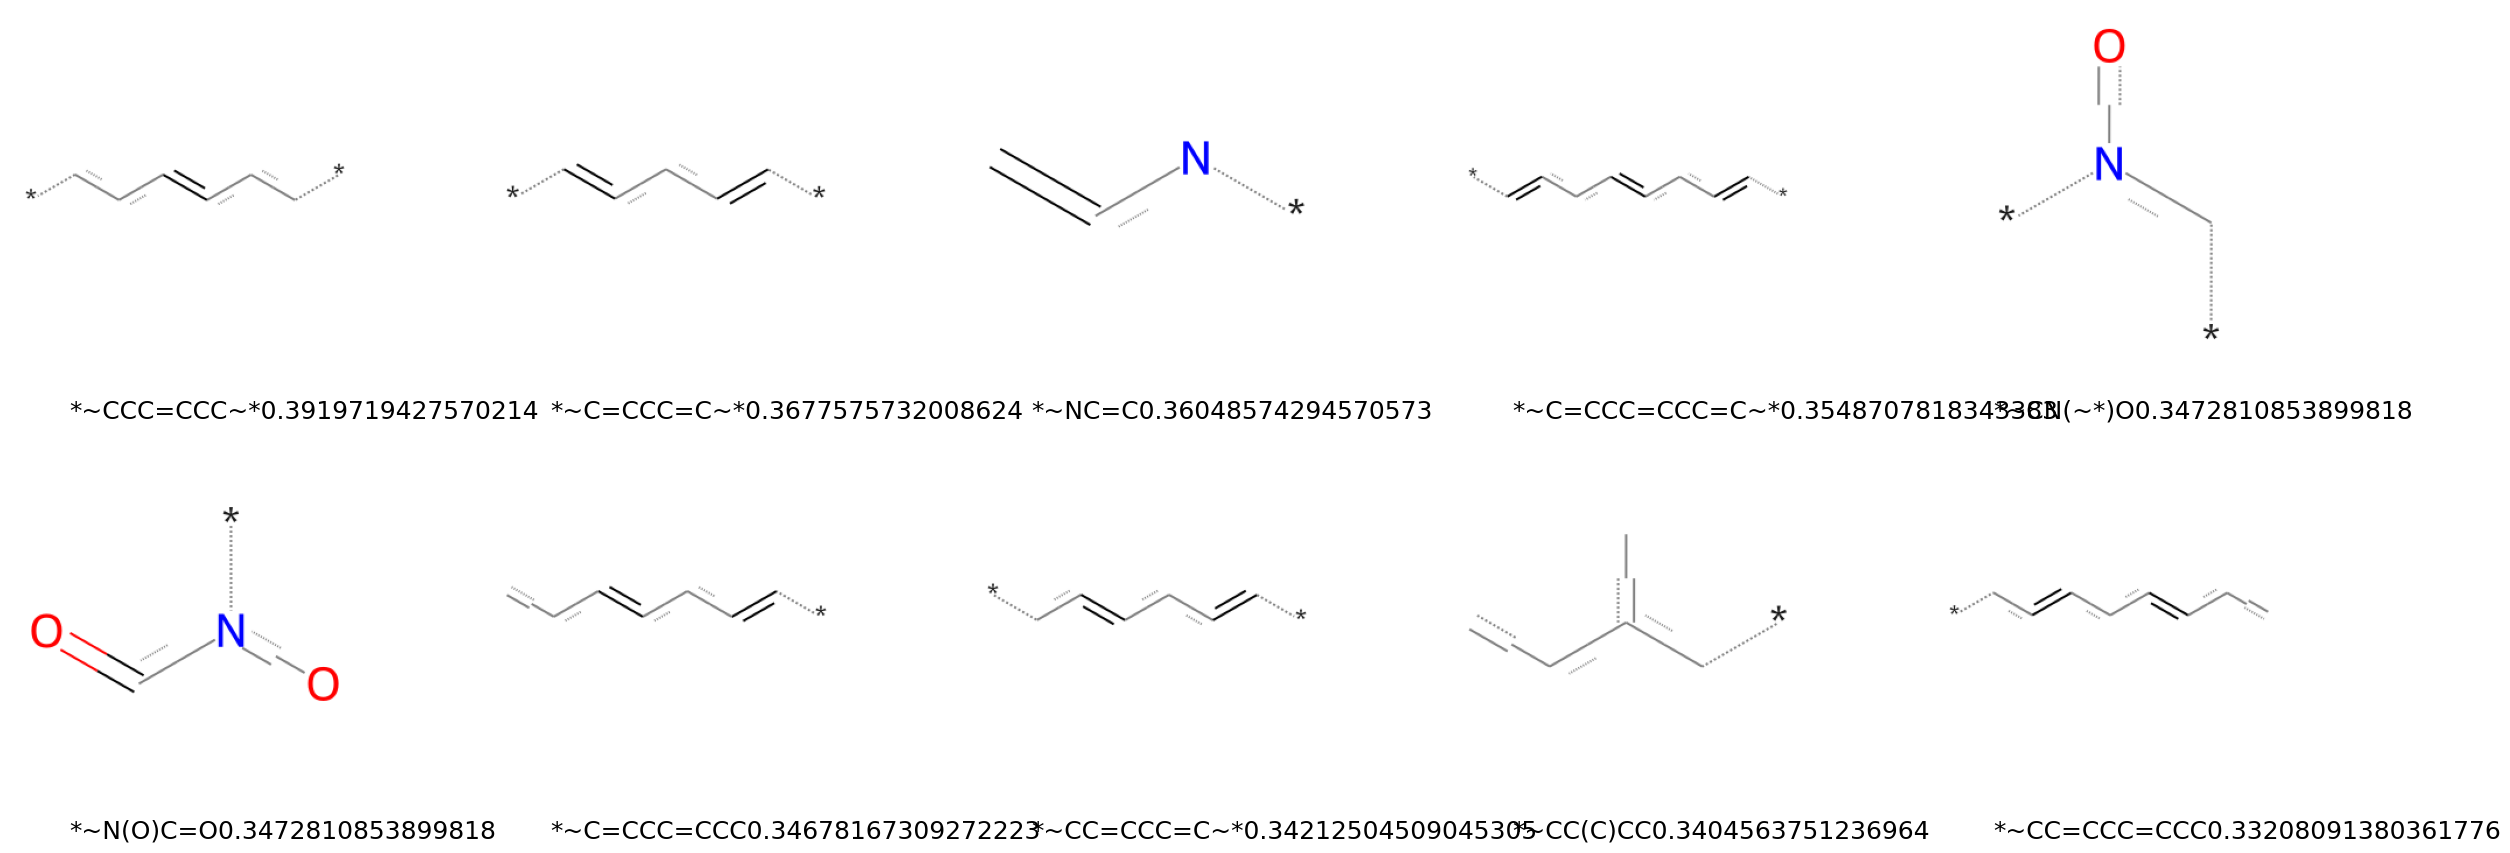

In [64]:
# top 10 highest scores
top = 10
labels = list()
for f, s in sub_df[['sub_list', 'score']].values[:top]:
    labels.append(f + str(s))
drawGridMolecule([Chem.MolFromSmarts(f) for f in sub_df['sub_list'][:top]], labels=labels)

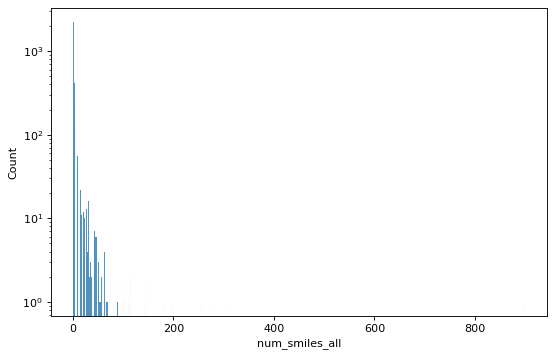

In [65]:
figure(figsize=(8, 5), dpi=80)
fig = sns.histplot(sub_df['num_smiles_all'])
fig.set_yscale("log")

## Percentile for selection

In [66]:
percentile = 90
if 't01' in args.file:
    percentile = 95
elif 't04' in args.file:
    percentile = 95
elif 't07' in args.file:
    percentile = 75
print(percentile)

95


6.0


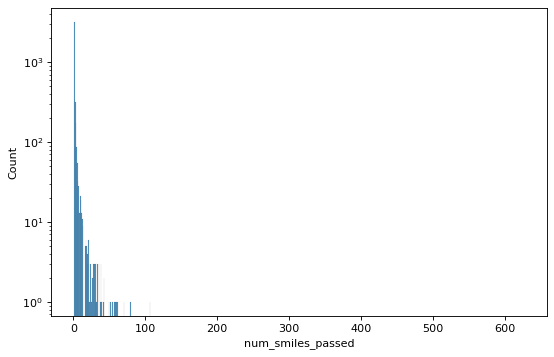

In [67]:
figure(figsize=(8, 5), dpi=80)
fig = sns.histplot(sub_df['num_smiles_passed'], bins=np.arange(0, max(sub_df['num_smiles_passed']), 1))
fig.set_yscale("log")
print(np.percentile(sub_df['num_smiles_passed'], percentile))

9.0


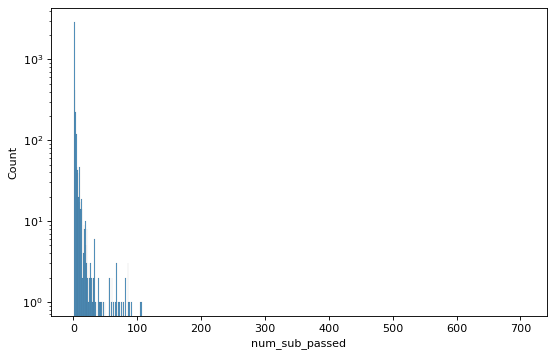

In [68]:
figure(figsize=(8, 5), dpi=80)
fig = sns.histplot(sub_df['num_sub_passed'], bins=np.arange(0, max(sub_df['num_sub_passed']), 1))
fig.set_yscale("log")
print(np.percentile(sub_df['num_sub_passed'], percentile))

In [69]:
sub_df.sort_values(by=['percent_smiles_passed','num_smiles_all'], ascending=False)

sub_list  num_sub_passed  num_smiles_passed  num_sub_all  \
115    *~C=CC=CC=CC=CC=C~*              11                 10           11   
108     *~C(~*)C(~*)(Cl)Cl              11                 10           11   
114   *~CC=CC=CC=CC=CC=C~*              12                 10           12   
138   *~C=CC=CC=CC=CC=CO~*               9                  9            9   
154   *~c1nc(~*)c(~*)[nH]1               8                  8            8   
...                    ...             ...                ...          ...   
3868     *~N=Nc1ccc(~*)cc1               1                  1          109   
1311             *~C(=O)OC               1                  1           70   
1794         *~c1ccc(N)cc1               1                  1          104   
1037    *~c1ccc(~*)c(~*)c1               3                  1          317   
725         *~c1ccc(~*)cc1               3                  2          672   

      num_smiles_all  percent_smiles_passed              fragment     score  
115               10             100.000000   *~C=CC=CC=CC=CC=C~*  0.125449  
108               10             100.000000    *~C(~*)C(~*)(Cl)Cl  0.123503  
114               10             100.000000  *~CC=CC=CC=CC=CC=C~*  0.089412  
138                9             100.000000  *~C=CC=CC=CC=CC=CO~*  0.100623  
154                8             100.000000  *~c1nc(~*)c(~*)[nH]1  0.247398  
...              ...                    ...                   ...       ...  
3868              55               1.818182     *~N=Nc1ccc(~*)cc1 -0.001498  
1311              63               1.587302             *~C(=O)OC -0.109191  
1794              69               1.449275         *~c1ccc(N)cc1 -0.019697  
1037             201               0.497512    *~c1ccc(~*)c(~*)c1 -0.030382  
725              444               0.450450        *~c1ccc(~*)cc1 -0.067117  

[4052 rows x 8 columns]

In [70]:
# sort by percentage of smiles that have important fragments and number of smiles that have fragments
# filter only number of smiles that have important fragments > "percentile" percentile and percentage of smiles that have important fragments > 50
sub_df_sorted = sub_df.sort_values(by=['percent_smiles_passed','num_smiles_all'], ascending=False)
sub_df_sorted_50 = sub_df_sorted[(sub_df_sorted['num_smiles_passed'] >= np.percentile(sub_df['num_smiles_passed'], percentile)) & (sub_df_sorted['percent_smiles_passed'] >= 50)] 
sub_df_sorted_50

sub_list  num_sub_passed  num_smiles_passed  num_sub_all  \
115     *~C=CC=CC=CC=CC=C~*              11                 10           11   
108      *~C(~*)C(~*)(Cl)Cl              11                 10           11   
114    *~CC=CC=CC=CC=CC=C~*              12                 10           12   
138    *~C=CC=CC=CC=CC=CO~*               9                  9            9   
154    *~c1nc(~*)c(~*)[nH]1               8                  8            8   
..                      ...             ...                ...          ...   
69   *~CON(OC(~*)=O)C(~*)=O              16                 16           31   
68   *~CON(OC(~*)=O)C(~*)~*              16                 16           31   
145         *~C(Cl)=C(~*)Cl               9                  8           22   
147              *~C(=O)CCl               8                  8           17   
205          *~NC(~*)C(~*)C              11                  6           19   

     num_smiles_all  percent_smiles_passed                fragment     score  
115              10             100.000000     *~C=CC=CC=CC=CC=C~*  0.125449  
108              10             100.000000      *~C(~*)C(~*)(Cl)Cl  0.123503  
114              10             100.000000    *~CC=CC=CC=CC=CC=C~*  0.089412  
138               9             100.000000    *~C=CC=CC=CC=CC=CO~*  0.100623  
154               8             100.000000    *~c1nc(~*)c(~*)[nH]1  0.247398  
..              ...                    ...                     ...       ...  
69               31              51.612903  *~CON(OC(~*)=O)C(~*)=O  0.072505  
68               31              51.612903  *~CON(OC(~*)=O)C(~*)~*  0.072505  
145              16              50.000000         *~C(Cl)=C(~*)Cl  0.181995  
147              16              50.000000              *~C(=O)CCl  0.119254  
205              12              50.000000          *~NC(~*)C(~*)C  0.088579  

[140 rows x 8 columns]

In [71]:
# sort by score and percentage of smiles that have important fragments
# filter only percentage of smiles that have important fragments > 50 and score > 0
sub_df_sorted = sub_df.sort_values(by=['score', 'percent_smiles_passed'], ascending=False)
sub_df_sorted_50 = sub_df_sorted[(sub_df_sorted['percent_smiles_passed'] >= 50) & (sub_df_sorted['score'] > 0)] 
sub_df_sorted_50

sub_list  num_sub_passed  num_smiles_passed  num_sub_all  \
4008          *~CCC=CCC~*               2                  1            2   
4002          *~C=CCC=C~*               2                  1            2   
3741               *~NC=C               1                  1            1   
4009      *~C=CCC=CCC=C~*               1                  1            1   
182             *~CN(~*)O               7                  7            7   
...                   ...             ...                ...          ...   
1086       *~NC(C)C(~*)=O               1                  1            6   
3940      *~CC=CC=CC=CS~*               1                  1            1   
978            *~NCCCCN~*               1                  1            2   
2140      *~NCC(~*)C(~*)N               1                  1            2   
3422  *~COC(=O)C(~*)(~*)O               1                  1            2   

      num_smiles_all  percent_smiles_passed             fragment     score  
4008               1                  100.0          *~CCC=CCC~*  0.391972  
4002               1                  100.0          *~C=CCC=C~*  0.367758  
3741               1                  100.0               *~NC=C  0.360486  
4009               1                  100.0      *~C=CCC=CCC=C~*  0.354871  
182                7                  100.0            *~CN(~*)O  0.347281  
...              ...                    ...                  ...       ...  
1086               2                   50.0       *~NC(C)C(~*)=O  0.009564  
3940               1                  100.0      *~CC=CC=CC=CS~*  0.007768  
978                1                  100.0           *~NCCCCN~*  0.003803  
2140               2                   50.0      *~NCC(~*)C(~*)N  0.002507  
3422               2                   50.0  *~COC(=O)C(~*)(~*)O  0.000720  

[2857 rows x 8 columns]

## Final condition!! -> Potential Substructures

In [72]:
# sort by percentage of smiles that have important fragments and number of smiles that have fragments
# filter only number of smiles that have important fragments > "percentile" percentile and percentage of smiles that have important fragments > 50 and score > 0
sub_df_sorted = sub_df.sort_values(by=['percent_smiles_passed','num_smiles_all'], ascending=False)
sub_df_sorted_50 = sub_df_sorted[(sub_df_sorted['num_smiles_passed'] >= np.percentile(sub_df['num_smiles_passed'], percentile)) & (sub_df_sorted['percent_smiles_passed'] >= 50) & (sub_df_sorted['score'] > 0)] 
display(len(sub_df_sorted_50), sub_df_sorted_50)

140

sub_list  num_sub_passed  num_smiles_passed  num_sub_all  \
115     *~C=CC=CC=CC=CC=C~*              11                 10           11   
108      *~C(~*)C(~*)(Cl)Cl              11                 10           11   
114    *~CC=CC=CC=CC=CC=C~*              12                 10           12   
138    *~C=CC=CC=CC=CC=CO~*               9                  9            9   
154    *~c1nc(~*)c(~*)[nH]1               8                  8            8   
..                      ...             ...                ...          ...   
69   *~CON(OC(~*)=O)C(~*)=O              16                 16           31   
68   *~CON(OC(~*)=O)C(~*)~*              16                 16           31   
145         *~C(Cl)=C(~*)Cl               9                  8           22   
147              *~C(=O)CCl               8                  8           17   
205          *~NC(~*)C(~*)C              11                  6           19   

     num_smiles_all  percent_smiles_passed                fragment     score  
115              10             100.000000     *~C=CC=CC=CC=CC=C~*  0.125449  
108              10             100.000000      *~C(~*)C(~*)(Cl)Cl  0.123503  
114              10             100.000000    *~CC=CC=CC=CC=CC=C~*  0.089412  
138               9             100.000000    *~C=CC=CC=CC=CC=CO~*  0.100623  
154               8             100.000000    *~c1nc(~*)c(~*)[nH]1  0.247398  
..              ...                    ...                     ...       ...  
69               31              51.612903  *~CON(OC(~*)=O)C(~*)=O  0.072505  
68               31              51.612903  *~CON(OC(~*)=O)C(~*)~*  0.072505  
145              16              50.000000         *~C(Cl)=C(~*)Cl  0.181995  
147              16              50.000000              *~C(=O)CCl  0.119254  
205              12              50.000000          *~NC(~*)C(~*)C  0.088579  

[140 rows x 8 columns]

## Save results

In [73]:
path_fold = 'dataset/'+file
if len(args.reduced) > 0:
    sub_df_sorted_50.to_csv(path_fold+'/potentsub_'+args.reduced[0]+"_"+args.schema+"_class"+str(predicted)+".csv")
else:
    sub_df_sorted_50.to_csv(path_fold+'/potentsub_'+args.schema+"_class"+str(predicted)+".csv")

## Detect redundancy and get only largest potential substructures

In [74]:
Fragments = list(sub_df_sorted_50['sub_list'])
Fragments_del_list = []
for i in tqdm(range(len(Fragments)-1)):
    for j in range(i+1,len(Fragments)):
        try:
            patt1 = Chem.MolFromSmarts(Fragments[i])
            patt2 = Chem.MolFromSmarts(Fragments[j])
            smiles1 = Chem.MolFromSmiles(Fragments[i])
            smiles2 = Chem.MolFromSmiles(Fragments[j])
            frag1 = smiles2.HasSubstructMatch(patt1)
            frag2 = smiles1.HasSubstructMatch(patt2)
            if frag1 == True:
                if frag2 == False:
                    Fragments_del_list.append(Fragments[i])
            if frag2 == True:
                if frag1 == False:
                    Fragments_del_list.append(Fragments[j])
            if frag1 == False:
                if frag2 == False:
                    pass
        except:
            pass
Final_Fragments_list = [f for f in Fragments if f not in Fragments_del_list]
print(len(Final_Fragments_list), Final_Fragments_list)

100%|██████████| 139/139 [00:01<00:00, 84.87it/s] 

25 ['*~C=CC=CC=CC=CC=CO~*', '*~c1nc(~*)c(~*)[nH]1', '*~C=CC=CC=CC=CC=CCC', '*~C(~*)C(Cl)(Cl)Cl', '*~CC=CC=CC=CC=COC~*', '*~CN=[N+]=[N-]', '*~COS(O)(=O)=O', '*~NS(C)(=O)=O', '*~C(Cl)=C(Cl)Cl', '*~C1OC1C(~*)=O', '*~N(CCCl)N=O', '*~C(=O)C(C)Br', '*~[N+](=O)[O-]', '*~C1(C)CO1', '*~N(~*)OCCCC', '*~C(=O)ON(~*)C(C)=O', '*~ON(OC(C)=O)C(~*)=O', '*~CCC1CO1', '*~C(Br)Br', '*~N=[N+](~*)[O-]', '*~CON(~*)OC(C)=O', '*~OCC1CO1', '*~CON(OC(~*)=O)C(~*)=O', '*~C(=O)CCl', '*~NC(~*)C(~*)C']


## Save result again (unique)

In [75]:
sub_df_sorted_50_unique = sub_df_sorted_50[sub_df_sorted_50['sub_list'].isin(Final_Fragments_list)]
if len(args.reduced) > 0:
    sub_df_sorted_50_unique.to_csv(path_fold+'/potentsub_'+args.reduced[0]+"_"+args.schema+"_class"+str(predicted)+"_unique.csv")
else:
    sub_df_sorted_50_unique.to_csv(path_fold+'/potentsub_'+args.schema+"_class"+str(predicted)+"_unique.csv")

print(len(sub_df_sorted_50_unique))
display(sub_df_sorted_50_unique)

25


sub_list  num_sub_passed  num_smiles_passed  num_sub_all  \
138    *~C=CC=CC=CC=CC=CO~*               9                  9            9   
154    *~c1nc(~*)c(~*)[nH]1               8                  8            8   
152     *~C=CC=CC=CC=CC=CCC               8                  8            8   
96       *~C(~*)C(Cl)(Cl)Cl              12                 11           13   
171     *~CC=CC=CC=CC=COC~*               7                  7            8   
25           *~CN=[N+]=[N-]              32                 32           40   
160          *~COS(O)(=O)=O               7                  7            9   
173           *~NS(C)(=O)=O               7                  7            9   
105         *~C(Cl)=C(Cl)Cl              10                 10           14   
203          *~C1OC1C(~*)=O               6                  6            8   
167            *~N(CCCl)N=O               7                  7           10   
168           *~C(=O)C(C)Br               7                  7           10   
0            *~[N+](=O)[O-]             707                628         1135   
129              *~C1(C)CO1               9                  9           13   
188            *~N(~*)OCCCC               6                  6            9   
209     *~C(=O)ON(~*)C(C)=O               6                  6            9   
87     *~ON(OC(C)=O)C(~*)=O              12                 12           22   
186               *~CCC1CO1               6                  6           13   
180               *~C(Br)Br               7                  7           18   
146        *~N=[N+](~*)[O-]               8                  8           15   
94         *~CON(~*)OC(C)=O              11                 11           21   
39                *~OCC1CO1              24                 23           52   
69   *~CON(OC(~*)=O)C(~*)=O              16                 16           31   
147              *~C(=O)CCl               8                  8           17   
205          *~NC(~*)C(~*)C              11                  6           19   

     num_smiles_all  percent_smiles_passed                fragment     score  
138               9             100.000000    *~C=CC=CC=CC=CC=CO~*  0.100623  
154               8             100.000000    *~c1nc(~*)c(~*)[nH]1  0.247398  
152               8             100.000000     *~C=CC=CC=CC=CC=CCC  0.091001  
96               12              91.666667      *~C(~*)C(Cl)(Cl)Cl  0.107216  
171               8              87.500000     *~CC=CC=CC=CC=COC~*  0.081765  
25               39              82.051282          *~CN=[N+]=[N-]  0.138483  
160               9              77.777778          *~COS(O)(=O)=O  0.227525  
173               9              77.777778           *~NS(C)(=O)=O  0.075123  
105              13              76.923077         *~C(Cl)=C(Cl)Cl  0.249614  
203               8              75.000000          *~C1OC1C(~*)=O  0.147001  
167              10              70.000000            *~N(CCCl)N=O  0.172947  
168              10              70.000000           *~C(=O)C(C)Br  0.128756  
0               898              69.933185          *~[N+](=O)[O-]  0.249441  
129              13              69.230769              *~C1(C)CO1  0.165948  
188               9              66.666667            *~N(~*)OCCCC  0.102647  
209               9              66.666667     *~C(=O)ON(~*)C(C)=O  0.097995  
87               22              54.545455    *~ON(OC(C)=O)C(~*)=O  0.079765  
186              11              54.545455               *~CCC1CO1  0.067238  
180              13              53.846154               *~C(Br)Br  0.076311  
146              15              53.333333        *~N=[N+](~*)[O-]  0.109267  
94               21              52.380952        *~CON(~*)OC(C)=O  0.092406  
39               44              52.272727               *~OCC1CO1  0.151367  
69               31              51.612903  *~CON(OC(~*)=O)C(~*)=O  0.072505  
147              16              50.000000              *~C(=O)CCl  

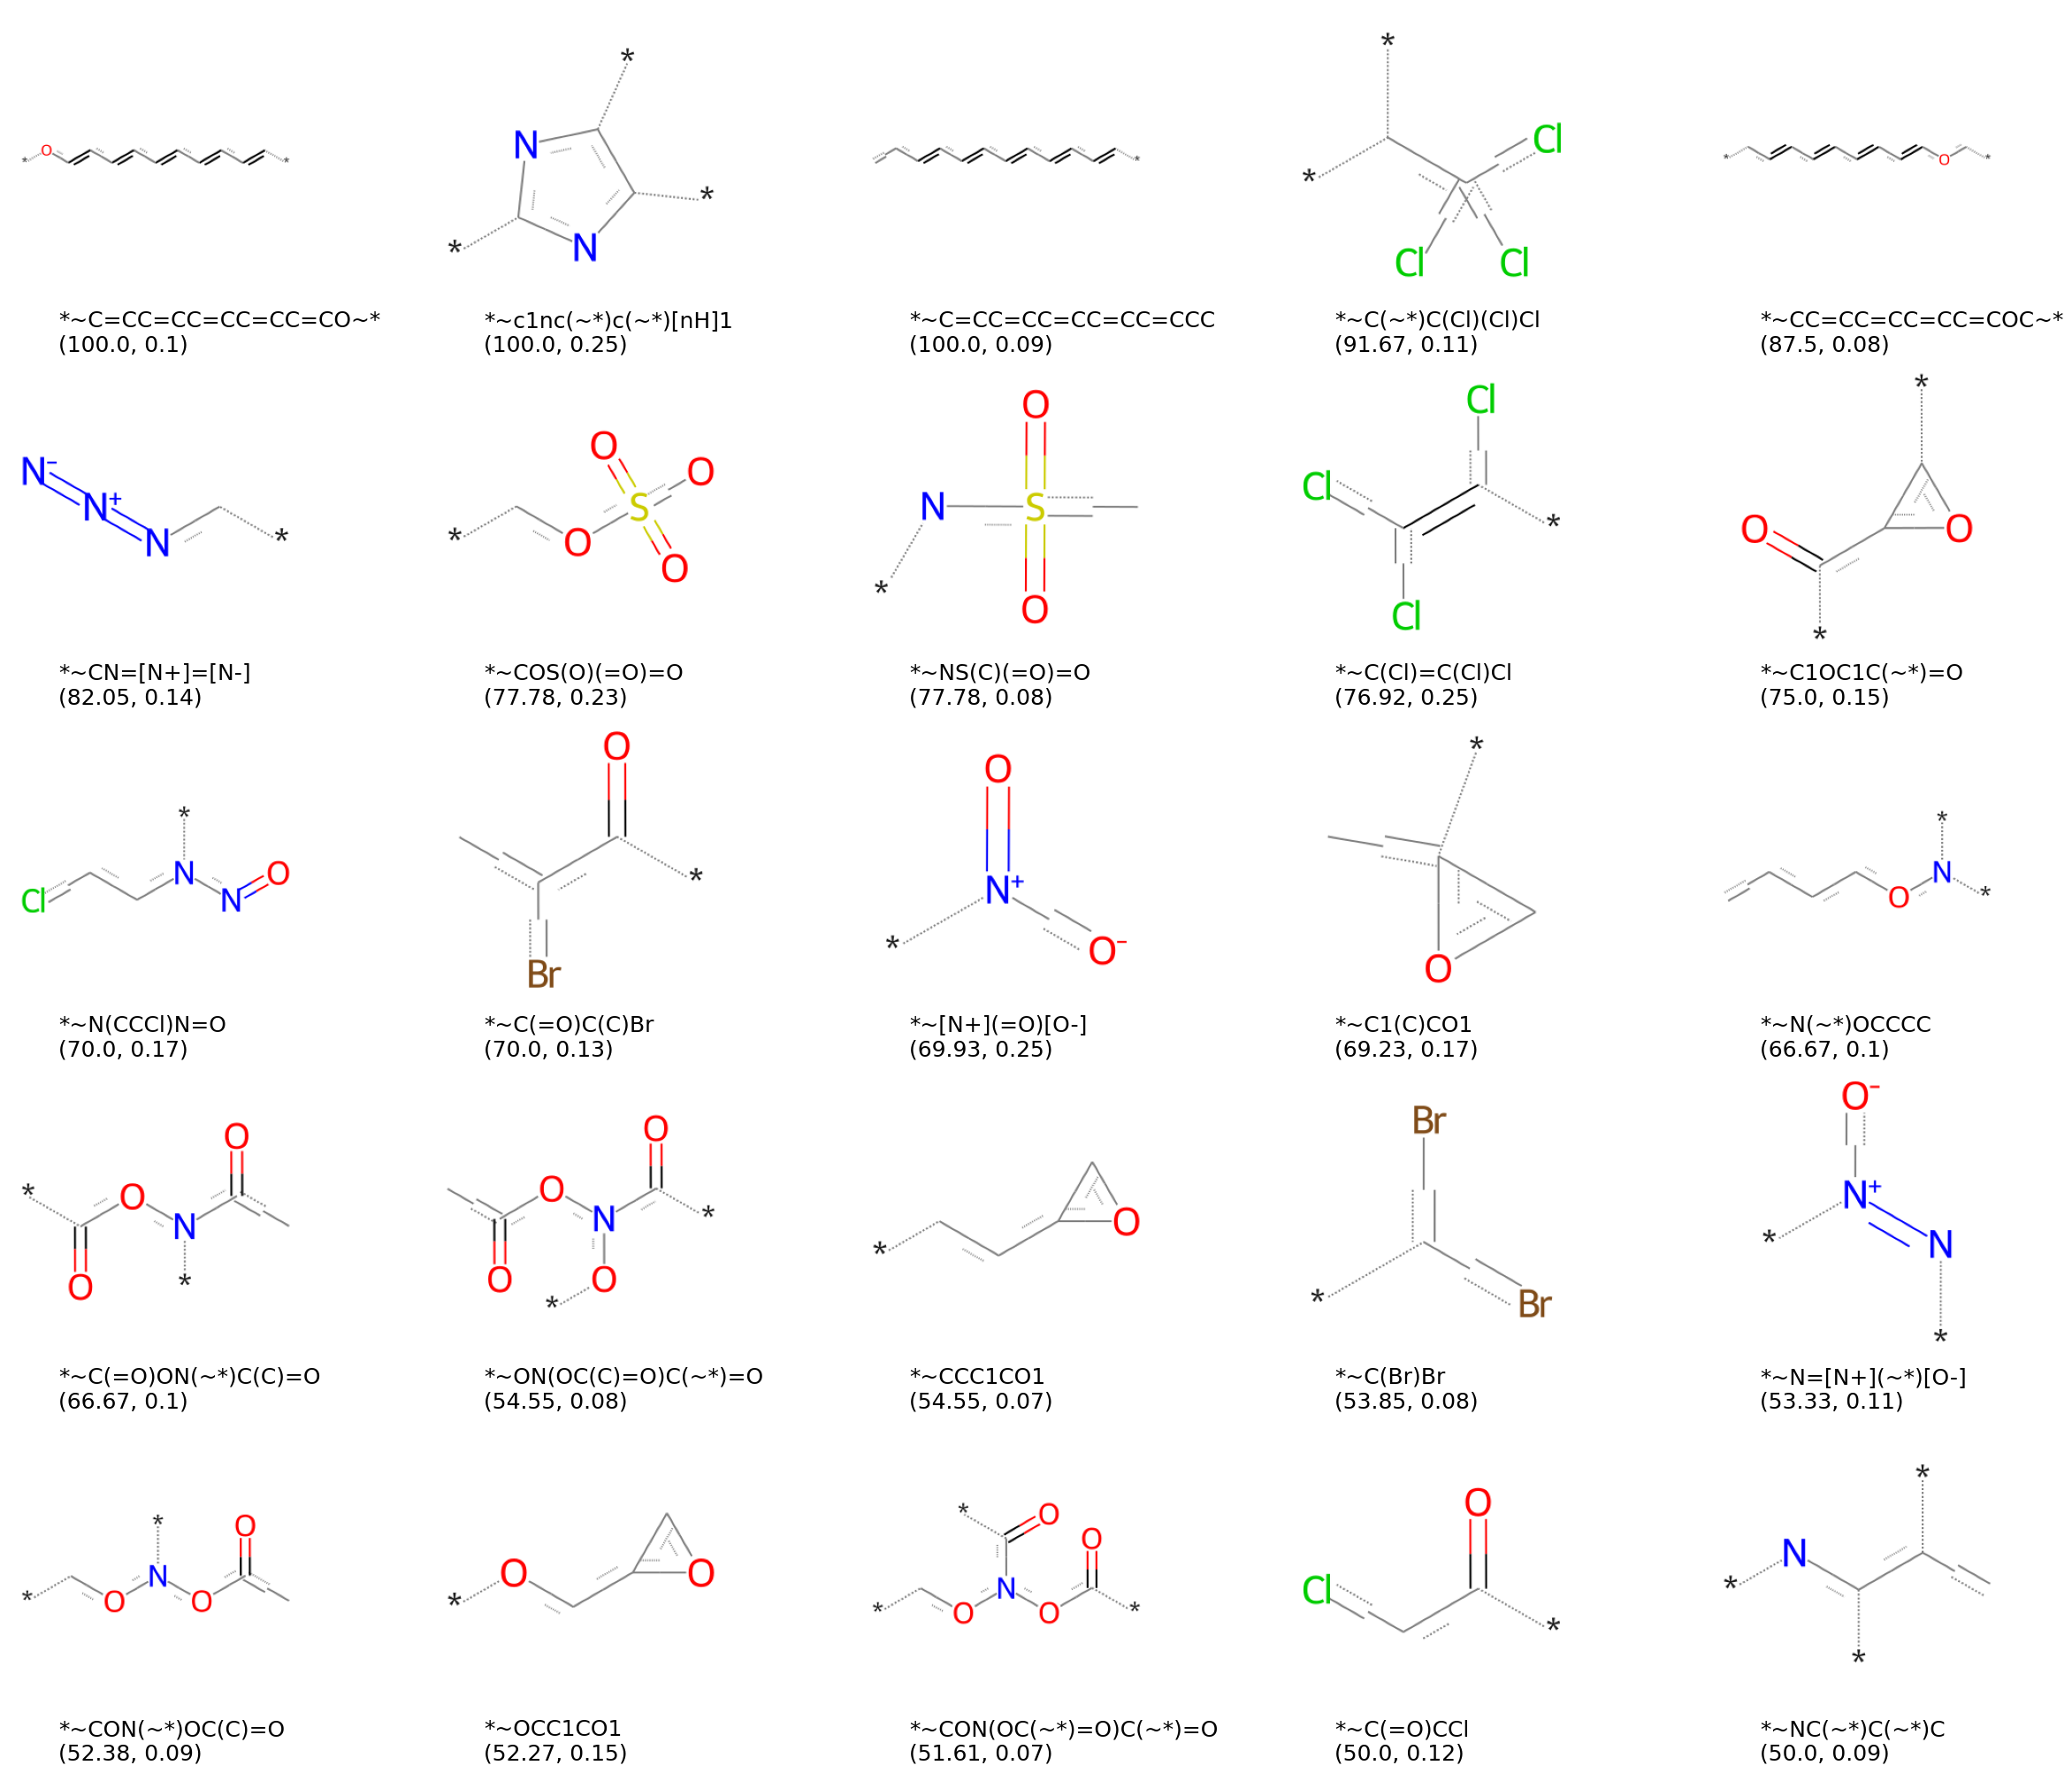

In [76]:
# drawGridMolecule([Chem.MolFromSmarts(f) for f in sub_df_sorted_50['sub_list']], labels=list(zip(sub_df_sorted_50['sub_list'],sub_df_sorted_50['score'])))
label_list = [s1+'\n'+str(s2) for s1, s2 in zip(sub_df_sorted_50_unique['sub_list'], zip(sub_df_sorted_50_unique['percent_smiles_passed'].round(decimals=2), sub_df_sorted_50_unique['score'].round(decimals=2)))]
drawGridMolecule([Chem.MolFromSmarts(f) for f in sub_df_sorted_50_unique['sub_list']], labels=label_list)
# drawGridMolecule([Chem.MolFromSmarts(f) for f in Final_Fragments_list], labels=list(Final_Fragments_list))


# Class 0

In [77]:
predicted = 0
sub_df = sub_df_dict[predicted]
df_score = df_score_dict[predicted]

In [78]:
# calculate percentage of smiles that have important fragments/ all smiles
sub_df['percent_smiles_passed'] = (sub_df['num_smiles_passed']/sub_df['num_smiles_all'])*100
sub_df

sub_list  num_sub_passed  num_smiles_passed  num_sub_all  \
0               *~CC(~*)=O             187                133          687   
1                 *~C(O)=O             133                126          461   
2            *~S(~*)(=O)=O             153                121          202   
3               *~OC(~*)=O             111                 98          500   
4               *~NC(~*)=O             134                 94          396   
...                    ...             ...                ...          ...   
4793  CCCCCCCCCCCCc1ccccc1               1                  1            1   
4794       *~CN(~*)C(~*)CO               1                  1            1   
4795       *~CN(~*)C(=O)CO               1                  1            1   
4796          *~C1CCCCC1~*               1                  1            3   
4797           *~C1CCCCC1C               1                  1            1   

      num_smiles_all  percent_smiles_passed  
0                346              38.439306  
1                351              35.897436  
2                148              81.756757  
3                354              27.683616  
4                239              39.330544  
...              ...                    ...  
4793               1             100.000000  
4794               1             100.000000  
4795               1             100.000000  
4796               3              33.333333  
4797               1             100.000000  

[4798 rows x 6 columns]

In [79]:
# merge statistics with scores and sort by scores
sub_df = sub_df.merge(df_score, how='inner', left_on='sub_list', right_on='fragment').sort_values(by=['score'], ascending=False)
sub_df

sub_list  num_sub_passed  num_smiles_passed  num_sub_all  \
191             *~C1CO1               6                  6            7   
2331         *~CN1CCCC1               1                  1            1   
1042     *~SC(~*)(Cl)Cl               1                  1            1   
1053      *~SC(~*)(F)Cl               1                  1            1   
1047     *~SC(~*)(~*)Cl               1                  1            1   
...                 ...             ...                ...          ...   
2150     *~c1ccc(~*)cc1               1                  1          428   
1571      *~[N+](C)(C)C               1                  1            7   
1371  *~CC(~*)CNC(~*)=O               1                  1            9   
1375   *~CC(O)CNC(~*)=O               1                  1            9   
2108              *~CSC               1                  1           18   

      num_smiles_all  percent_smiles_passed           fragment     score  
191                7              85.714286            *~C1CO1  0.411927  
2331               1             100.000000         *~CN1CCCC1  0.388819  
1042               1             100.000000     *~SC(~*)(Cl)Cl  0.371103  
1053               1             100.000000      *~SC(~*)(F)Cl  0.371103  
1047               1             100.000000     *~SC(~*)(~*)Cl  0.371103  
...              ...                    ...                ...       ...  
2150             305               0.327869     *~c1ccc(~*)cc1 -0.102831  
1571               7              14.285714      *~[N+](C)(C)C -0.122107  
1371               3              33.333333  *~CC(~*)CNC(~*)=O -0.125980  
1375               3              33.333333   *~CC(O)CNC(~*)=O -0.125980  
2108              10              10.000000              *~CSC -0.136004  

[4798 rows x 8 columns]

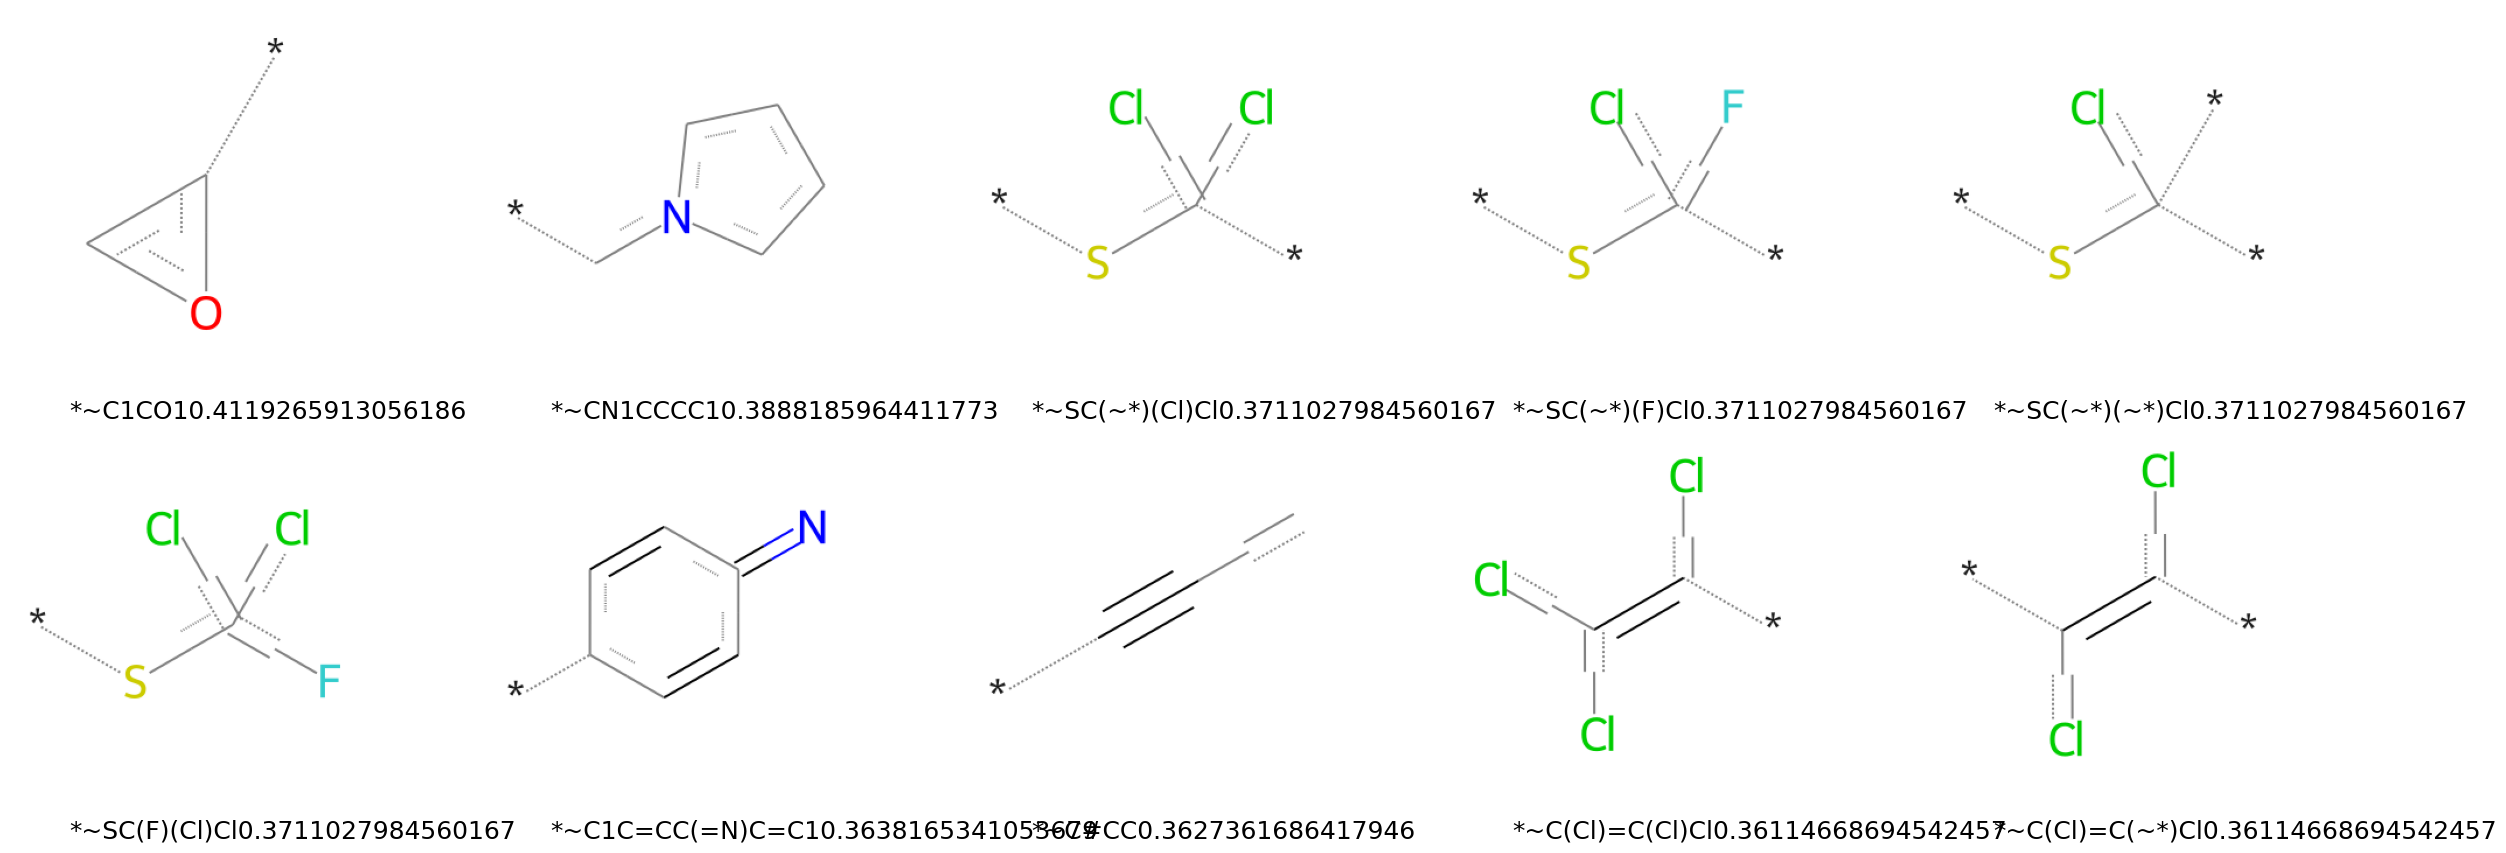

In [80]:
# top 10 highest scores
top = 10
labels = list()
for f, s in sub_df[['sub_list', 'score']].values[:top]:
    labels.append(f + str(s))
drawGridMolecule([Chem.MolFromSmarts(f) for f in sub_df['sub_list'][:top]], labels=labels)

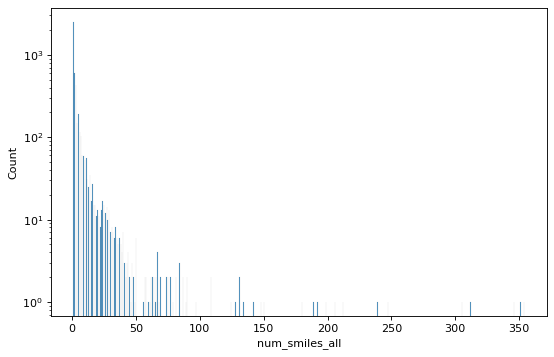

In [81]:
figure(figsize=(8, 5), dpi=80)
fig = sns.histplot(sub_df['num_smiles_all'])
fig.set_yscale("log")

## Percentile for selection

In [82]:
percentile = 90
if 't01' in args.file:
    percentile = 95
elif 't04' in args.file:
    percentile = 95
elif 't07' in args.file:
    percentile = 75
print(percentile)

95


5.0


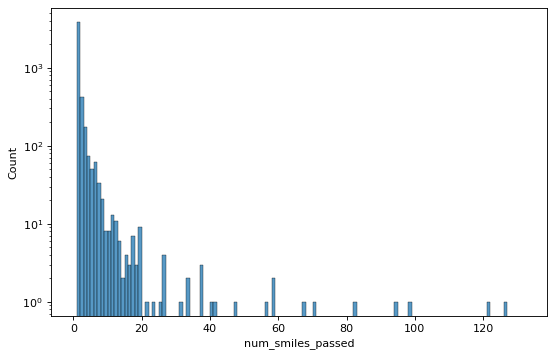

In [83]:
figure(figsize=(8, 5), dpi=80)
fig = sns.histplot(sub_df['num_smiles_passed'], bins=np.arange(0, max(sub_df['num_smiles_passed']), 1))
fig.set_yscale("log")
print(np.percentile(sub_df['num_smiles_passed'], percentile))

8.0


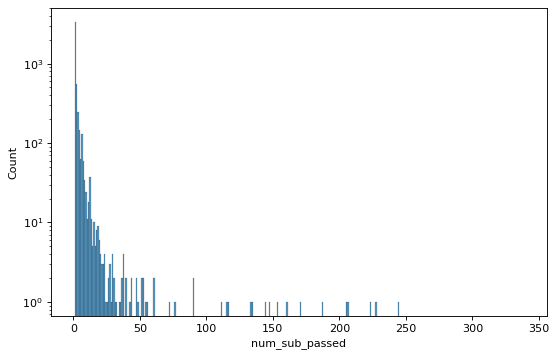

In [84]:
figure(figsize=(8, 5), dpi=80)
fig = sns.histplot(sub_df['num_sub_passed'], bins=np.arange(0, max(sub_df['num_sub_passed']), 1))
fig.set_yscale("log")
print(np.percentile(sub_df['num_sub_passed'], percentile))

In [85]:
sub_df.sort_values(by=['percent_smiles_passed','num_smiles_all'], ascending=False)

sub_list  num_sub_passed  num_smiles_passed  num_sub_all  \
209            *~C(=O)Cl               6                  6            6   
213   *~OC(=O)C(~*)(~*)O               6                  6            6   
252           *~C(~*)CCl               6                  5            6   
324           *~C(=O)CCl               4                  4            4   
315          *~N(~*)CCCl               7                  4            7   
...                  ...             ...                ...          ...   
217           *~c1ccccc1               8                  5          717   
2621     *~C(~*)c1ccccc1               3                  1          108   
1335         *~Cc1ccccc1               1                  1          158   
1218  *~c1ccc(~*)c(~*)c1              17                  1          225   
2150      *~c1ccc(~*)cc1               1                  1          428   

      num_smiles_all  percent_smiles_passed            fragment     score  
209                6             100.000000           *~C(=O)Cl  0.253118  
213                6             100.000000  *~OC(=O)C(~*)(~*)O  0.151363  
252                5             100.000000          *~C(~*)CCl  0.254178  
324                4             100.000000          *~C(=O)CCl  0.240671  
315                4             100.000000         *~N(~*)CCCl  0.232080  
...              ...                    ...                 ...       ...  
217              312               1.602564          *~c1ccccc1 -0.090755  
2621              67               1.492537     *~C(~*)c1ccccc1 -0.035714  
1335              87               1.149425         *~Cc1ccccc1 -0.062514  
1218             150               0.666667  *~c1ccc(~*)c(~*)c1 -0.050038  
2150             305               0.327869      *~c1ccc(~*)cc1 -0.102831  

[4798 rows x 8 columns]

In [86]:
# sort by percentage of smiles that have important fragments and number of smiles that have fragments
# filter only number of smiles that have important fragments > "percentile" percentile and percentage of smiles that have important fragments > 50
sub_df_sorted = sub_df.sort_values(by=['percent_smiles_passed','num_smiles_all'], ascending=False)
sub_df_sorted_50 = sub_df_sorted[(sub_df_sorted['num_smiles_passed'] >= np.percentile(sub_df['num_smiles_passed'], percentile)) & (sub_df_sorted['percent_smiles_passed'] >= 50)] 
sub_df_sorted_50

sub_list  num_sub_passed  num_smiles_passed  num_sub_all  \
209           *~C(=O)Cl               6                  6            6   
213  *~OC(=O)C(~*)(~*)O               6                  6            6   
252          *~C(~*)CCl               6                  5            6   
16       *~NS(~*)(=O)=O              37                 37           40   
15       *~NS(~*)(~*)=O              37                 37           40   
..                  ...             ...                ...          ...   
71   *~C(=O)C(~*)(~*)~*              12                 12           25   
93            *~CC=CC~*              12                  9          110   
130          *~CCCC=C~*              14                  7           38   
205          *~OCC(O)=O               6                  6           12   
225        *~C(~*)C(C)C               7                  5           37   

     num_smiles_all  percent_smiles_passed            fragment     score  
209               6                  100.0           *~C(=O)Cl  0.253118  
213               6                  100.0  *~OC(=O)C(~*)(~*)O  0.151363  
252               5                  100.0          *~C(~*)CCl  0.254178  
16               40                   92.5      *~NS(~*)(=O)=O  0.274219  
15               40                   92.5      *~NS(~*)(~*)=O  0.274219  
..              ...                    ...                 ...       ...  
71               24                   50.0  *~C(=O)C(~*)(~*)~*  0.112964  
93               18                   50.0           *~CC=CC~*  0.072568  
130              14                   50.0          *~CCCC=C~*  0.110404  
205              12                   50.0          *~OCC(O)=O  0.089636  
225              10                   50.0        *~C(~*)C(C)C  0.082374  

[69 rows x 8 columns]

In [87]:
# sort by score and percentage of smiles that have important fragments
# filter only percentage of smiles that have important fragments > 50 and score > 0
sub_df_sorted = sub_df.sort_values(by=['score', 'percent_smiles_passed'], ascending=False)
sub_df_sorted_50 = sub_df_sorted[(sub_df_sorted['percent_smiles_passed'] >= 50) & (sub_df_sorted['score'] > 0)] 
sub_df_sorted_50

sub_list  num_sub_passed  num_smiles_passed  num_sub_all  \
191                *~C1CO1               6                  6            7   
2331            *~CN1CCCC1               1                  1            1   
1042        *~SC(~*)(Cl)Cl               1                  1            1   
1053         *~SC(~*)(F)Cl               1                  1            1   
1047        *~SC(~*)(~*)Cl               1                  1            1   
...                    ...             ...                ...          ...   
4754     *~CO[Si](~*)(~*)C               1                  1            3   
2249       *~C(~*)COC(~*)C               1                  1            6   
2287       *~C(~*)COC(C)=O               1                  1            6   
3456   *~COCCOCCCCCCCCCCCC               1                  1            1   
3467  *~CCCCCCCCCCCOCCOC~*               1                  1            1   

      num_smiles_all  percent_smiles_passed              fragment     score  
191                7              85.714286               *~C1CO1  0.411927  
2331               1             100.000000            *~CN1CCCC1  0.388819  
1042               1             100.000000        *~SC(~*)(Cl)Cl  0.371103  
1053               1             100.000000         *~SC(~*)(F)Cl  0.371103  
1047               1             100.000000        *~SC(~*)(~*)Cl  0.371103  
...              ...                    ...                   ...       ...  
4754               1             100.000000     *~CO[Si](~*)(~*)C  0.009643  
2249               2              50.000000       *~C(~*)COC(~*)C  0.008409  
2287               2              50.000000       *~C(~*)COC(C)=O  0.008409  
3456               1             100.000000   *~COCCOCCCCCCCCCCCC  0.004171  
3467               1             100.000000  *~CCCCCCCCCCCOCCOC~*  0.004171  

[3283 rows x 8 columns]

## Final condition!! -> Potential Substructures

In [88]:
# sort by percentage of smiles that have important fragments and number of smiles that have fragments
# filter only number of smiles that have important fragments > "percentile" percentile and percentage of smiles that have important fragments > 50 and score > 0
sub_df_sorted = sub_df.sort_values(by=['percent_smiles_passed','num_smiles_all'], ascending=False)
sub_df_sorted_50 = sub_df_sorted[(sub_df_sorted['num_smiles_passed'] >= np.percentile(sub_df['num_smiles_passed'], percentile)) & (sub_df_sorted['percent_smiles_passed'] >= 50) & (sub_df_sorted['score'] > 0)] 
display(len(sub_df_sorted_50), sub_df_sorted_50)

69

sub_list  num_sub_passed  num_smiles_passed  num_sub_all  \
209           *~C(=O)Cl               6                  6            6   
213  *~OC(=O)C(~*)(~*)O               6                  6            6   
252          *~C(~*)CCl               6                  5            6   
16       *~NS(~*)(=O)=O              37                 37           40   
15       *~NS(~*)(~*)=O              37                 37           40   
..                  ...             ...                ...          ...   
71   *~C(=O)C(~*)(~*)~*              12                 12           25   
93            *~CC=CC~*              12                  9          110   
130          *~CCCC=C~*              14                  7           38   
205          *~OCC(O)=O               6                  6           12   
225        *~C(~*)C(C)C               7                  5           37   

     num_smiles_all  percent_smiles_passed            fragment     score  
209               6                  100.0           *~C(=O)Cl  0.253118  
213               6                  100.0  *~OC(=O)C(~*)(~*)O  0.151363  
252               5                  100.0          *~C(~*)CCl  0.254178  
16               40                   92.5      *~NS(~*)(=O)=O  0.274219  
15               40                   92.5      *~NS(~*)(~*)=O  0.274219  
..              ...                    ...                 ...       ...  
71               24                   50.0  *~C(=O)C(~*)(~*)~*  0.112964  
93               18                   50.0           *~CC=CC~*  0.072568  
130              14                   50.0          *~CCCC=C~*  0.110404  
205              12                   50.0          *~OCC(O)=O  0.089636  
225              10                   50.0        *~C(~*)C(C)C  0.082374  

[69 rows x 8 columns]

## Save results

In [89]:
path_fold = 'dataset/'+file
if len(args.reduced) > 0:
    sub_df_sorted_50.to_csv(path_fold+'/potentsub_'+args.reduced[0]+"_"+args.schema+"_class"+str(predicted)+".csv")
else:
    sub_df_sorted_50.to_csv(path_fold+'/potentsub_'+args.schema+"_class"+str(predicted)+".csv")

## Detect redundancy and get only largest potential substructures

In [90]:
Fragments = list(sub_df_sorted_50['sub_list'])
Fragments_del_list = []
for i in tqdm(range(len(Fragments)-1)):
    for j in range(i+1,len(Fragments)):
        try:
            patt1 = Chem.MolFromSmarts(Fragments[i])
            patt2 = Chem.MolFromSmarts(Fragments[j])
            smiles1 = Chem.MolFromSmiles(Fragments[i])
            smiles2 = Chem.MolFromSmiles(Fragments[j])
            frag1 = smiles2.HasSubstructMatch(patt1)
            frag2 = smiles1.HasSubstructMatch(patt2)
            if frag1 == True:
                if frag2 == False:
                    Fragments_del_list.append(Fragments[i])
            if frag2 == True:
                if frag1 == False:
                    Fragments_del_list.append(Fragments[j])
            if frag1 == False:
                if frag2 == False:
                    pass
        except:
            pass
Final_Fragments_list = [f for f in Fragments if f not in Fragments_del_list]
print(len(Final_Fragments_list), Final_Fragments_list)

100%|██████████| 68/68 [00:00<00:00, 180.62it/s]

20 ['*~C(=O)Cl', '*~OC(=O)C(~*)(~*)O', '*~C1C=CC(=C(~*)~*)C=C1', '*~C(Cl)(Cl)Cl', '*~C(C)C(~*)C(~*)=O', '*~C(~*)C(~*)Cl', '*~NC(C(~*)~*)C(~*)=O', '*~NC(=O)NS(~*)(=O)=O', '*~C1OC1C(~*)=O', '*~CC(=O)N(~*)~*', '*~S(O)(=O)=O', '*~OC(~*)C(~*)=O', '*~CC(NC(=O)C~*)C(O)=O', '*~NC(=O)C(~*)C', '*~CN(~*)CCN(C)C', '*~S(C)(=O)=O', '*~C1C=CC(=[N+](~*)~*)C=C1', '*~C(=O)C(~*)(C)C', '*~CCCC=C~*', '*~OCC(O)=O']


## Save result again (unique)

In [91]:
sub_df_sorted_50_unique = sub_df_sorted_50[sub_df_sorted_50['sub_list'].isin(Final_Fragments_list)]
if len(args.reduced) > 0:
    sub_df_sorted_50_unique.to_csv(path_fold+'/potentsub_'+args.reduced[0]+"_"+args.schema+"_class"+str(predicted)+"_unique.csv")
else:
    sub_df_sorted_50_unique.to_csv(path_fold+'/potentsub_'+args.schema+"_class"+str(predicted)+"_unique.csv")

print(len(sub_df_sorted_50_unique))
display(sub_df_sorted_50_unique)

20


sub_list  num_sub_passed  num_smiles_passed  \
209                  *~C(=O)Cl               6                  6   
213         *~OC(=O)C(~*)(~*)O               6                  6   
127     *~C1C=CC(=C(~*)~*)C=C1               7                  7   
170              *~C(Cl)(Cl)Cl               6                  6   
167         *~C(C)C(~*)C(~*)=O              11                  6   
242             *~C(~*)C(~*)Cl               5                  5   
223       *~NC(C(~*)~*)C(~*)=O               8                  5   
263       *~NC(=O)NS(~*)(=O)=O               5                  5   
118             *~C1OC1C(~*)=O               8                  8   
152            *~CC(=O)N(~*)~*               8                  7   
8                 *~S(O)(=O)=O              90                 58   
250            *~OC(~*)C(~*)=O               5                  5   
178      *~CC(NC(=O)C~*)C(O)=O               6                  6   
142             *~NC(=O)C(~*)C              10                  7   
234            *~CN(~*)CCN(C)C               5                  5   
221               *~S(C)(=O)=O               5                  5   
248  *~C1C=CC(=[N+](~*)~*)C=C1               5                  5   
147           *~C(=O)C(~*)(C)C               7                  7   
130                 *~CCCC=C~*              14                  7   
205                 *~OCC(O)=O               6                  6   

     num_sub_all  num_smiles_all  percent_smiles_passed  \
209            6               6             100.000000   
213            6               6             100.000000   
127            8               8              87.500000   
170            7               7              85.714286   
167           14               7              85.714286   
242            6               6              83.333333   
223           13               6              83.333333   
263            6               6              83.333333   
118           12              10              80.000000   
152           10               9              77.777778   
8            126              75              77.333333   
250            7               7              71.428571   
178            9               9              66.666667   
142           14              11              63.636364   
234            8               8              62.500000   
221            8               8              62.500000   
248            9               9              55.555556   
147           13              13              53.846154   
130           38              14              50.000000   
205           12              12              50.000000   

                      fragment     score  
209                  *~C(=O)Cl  0.253118  
213         *~OC(=O)C(~*)(~*)O  0.151363  
127     *~C1C=CC(=C(~*)~*)C=C1  0.219275  
170              *~C(Cl)(Cl)Cl  0.292344  
167         *~C(C)C(~*)C(~*)=O  0.187240  
242             *~C(~*)C(~*)Cl  0.273508  
223       *~NC(C(~*)~*)C(~*)=O  0.183564  
263       *~NC(=O)NS(~*)(=O)=O  0.179234  
118             *~C1OC1C(~*)=O  0.211973  
152            *~CC(=O)N(~*)~*  0.158757  
8                 *~S(O)(=O)=O  0.278634  
250            *~OC(~*)C(~*)=O  0.147449  
178      *~CC(NC(=O)C~*)C(O)=O  0.139846  
142             *~NC(=O)C(~*)C  0.158481  
234            *~CN(~*)CCN(C)C  0.184972  
221               *~S(C)(=O)=O  0.163567  
248  *~C1C=CC(=[N+](~*)~*)C=C1  0.192517  
147           *~C(=O)C(~*)(C)C  0.139596  
130                 *~CCCC=C~*  0.110404  
205                 *~OCC(O)=O  0.089636

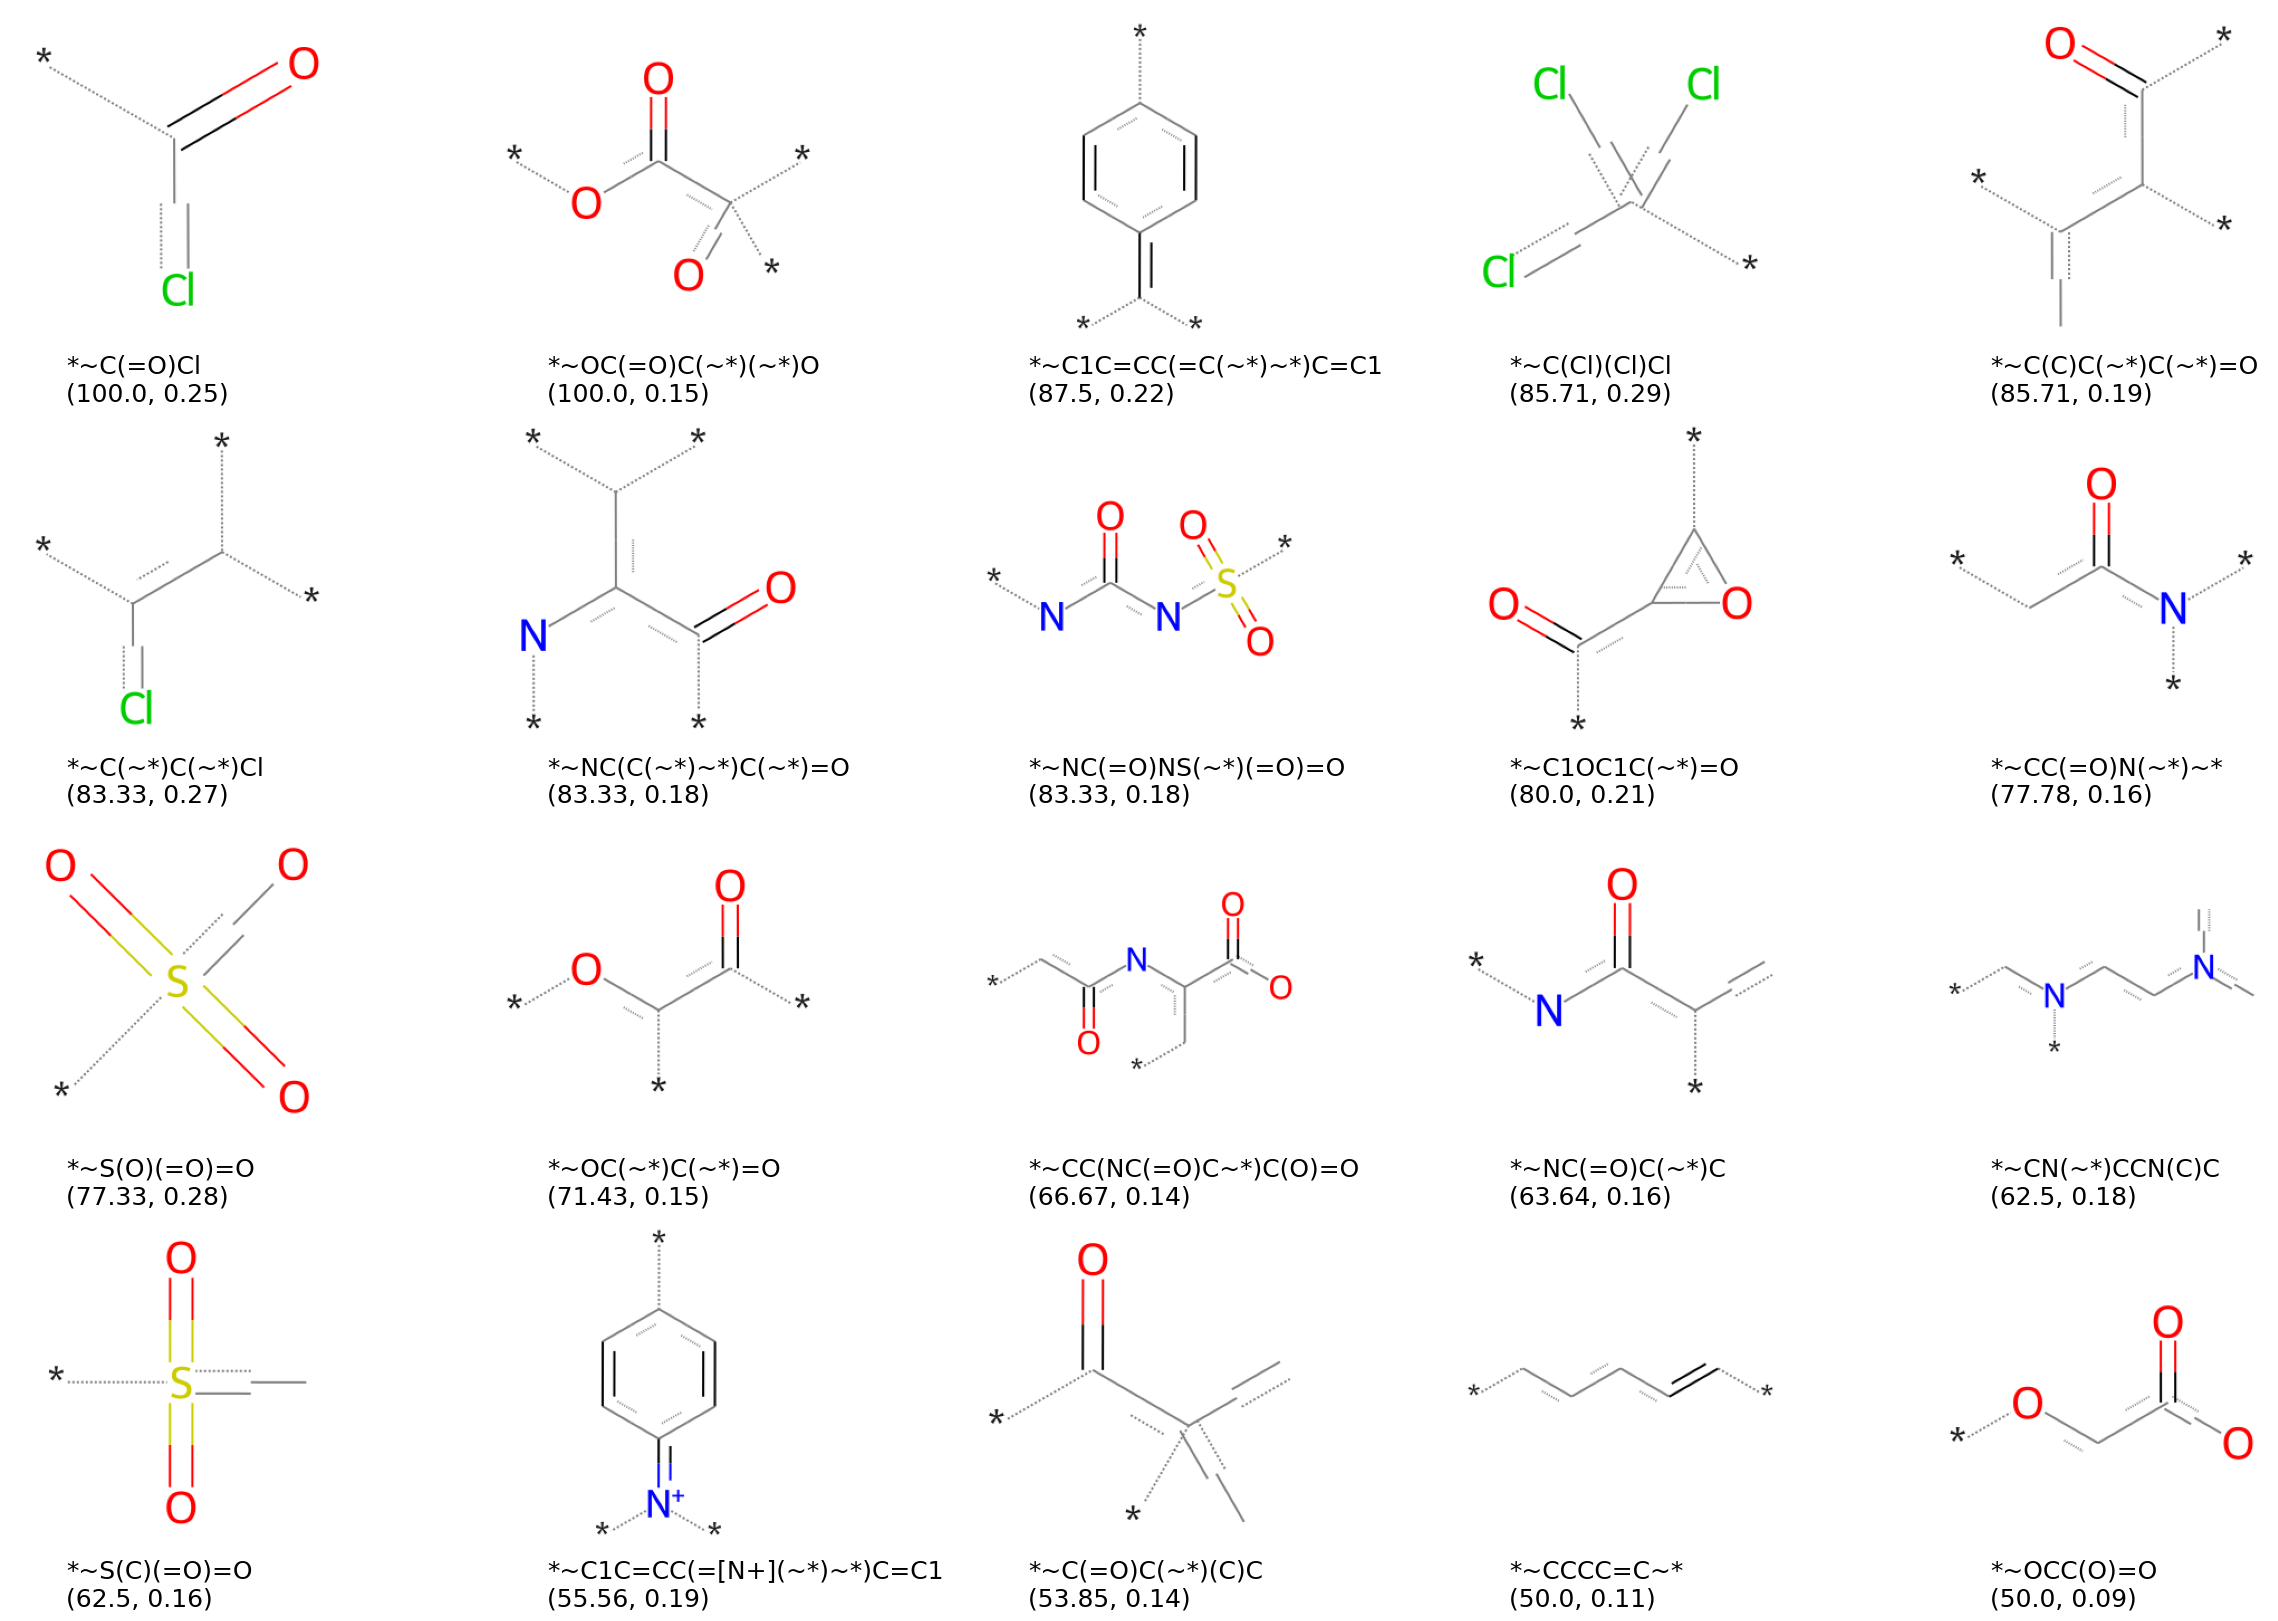

In [92]:
# drawGridMolecule([Chem.MolFromSmarts(f) for f in sub_df_sorted_50['sub_list']], labels=list(zip(sub_df_sorted_50['sub_list'],sub_df_sorted_50['score'])))
label_list = [s1+'\n'+str(s2) for s1, s2 in zip(sub_df_sorted_50_unique['sub_list'], zip(sub_df_sorted_50_unique['percent_smiles_passed'].round(decimals=2), sub_df_sorted_50_unique['score'].round(decimals=2)))]
drawGridMolecule([Chem.MolFromSmarts(f) for f in sub_df_sorted_50_unique['sub_list']], labels=label_list)
# drawGridMolecule([Chem.MolFromSmarts(f) for f in Final_Fragments_list], labels=list(Final_Fragments_list))
